In [1]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import random
import numpy as np
import pandas as pd
from models.aa_common.performance_metrics import *

In [2]:
task = "pmd"
# model_root_and_name_tuple_list = []
model_root_and_name_tuple_list = [("dbnsfp", "polyphen2_HVAR"), ("dbnsfp", "cadd"), ("dbnsfp", "mvp"), ("dbnsfp", "metarnn"), ("dbnsfp", "revel"),
                                  ("snpdbe", "sift_snpdbe"), 
                                  ("tape_rao", "unirep"), ("tape_rao", "protbert"), ("sequnet_dunham", "sequnet"), 
                                  ("esm_rives", "esm1b_t33_650M_UR50S"), ("esm_rives", "esm1v_t33_650M_UR90S"), ("esm_rives", "esm2_t33_650M_UR50D"),
                                  ("bioembeddings_dallago", "plus_rnn"), 
                                  ("bioembeddings_dallago", "prottrans_bert_bfd"), ("bioembeddings_dallago", "prottrans_albert_bfd"),
                                  ("bioembeddings_dallago", "prottrans_xlnet_uniref100"), 
                                  ("bioembeddings_dallago", "prottrans_t5_bfd"), ("bioembeddings_dallago", "prottrans_t5_uniref50"), ("bioembeddings_dallago", "prottrans_t5_xl_u50"),
                                  ("vespa_marquet", "vespa"), ("", "random_classifier"), ("", "conservation")]


# by default, we consider larger means positive class (here Effect), but the following models have specific opposite meaning
models_smaller_means_damaging = ["sequnet", "sift"]

metrics = ["KS-statistic", "KS-pvalue", "AUC-ROC", "AUC-PR", "F1-max", "Th-max", "Precision", "Recall", "Accuracy", "Balanced-accuracy", "MCC", "Missing values (%)"]

In [3]:
result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}.tsv", sep="\t")
print(result_df.shape)
print(result_df.columns)
result_df.rename(columns={"functional_effect": "class"}, inplace=True)
result_df["class"].value_counts()

(60306, 54)
Index(['mut_id', 'pmd_id', 'nr', 'crossref', 'uniprot_id', 'ensembl_id',
       'taxid', 'protein', 'mut_PMD', 'mut_real', 'wt', 'mut', 'prot_pos',
       'function_summarized', 'functional_effect', 'function', 'seq', 'snp_id',
       'mrna_acc', 'mrna_ver', 'mrna_pos', 'allele', 'protein_acc',
       'protein_ver', 'verified', 'chrom', 'chrom_pos', 'variation',
       'variant_type', 'ref_allele', 'alt_allele', 'pmd_nr_id', 'sift_pred',
       'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred', 'metarnn_pred',
       'revel_pred', 'unirep_pred', 'protbert_pred', 'sequnet_pred',
       'esm1b_t33_650M_UR50S_pred', 'esm1v_t33_650M_UR90S_pred',
       'esm2_t33_650M_UR50D_pred', 'plus_rnn_pred', 'prottrans_bert_bfd_pred',
       'prottrans_albert_bfd_pred', 'prottrans_xlnet_uniref100_pred',
       'prottrans_t5_bfd_pred', 'prottrans_t5_uniref50_pred',
       'prottrans_t5_xl_u50_pred', 'vespa_pred', 'conservation_pred',
       'sift_snpdbe_pred'],
      dtype='object')


Effect       30774
No-effect    15442
Knock-out    14090
Name: class, dtype: int64

### The following are the helper functions that computes the performance metrics for human and non-human analysis

In [11]:
def get_non_nan_df(df, col_name, positive_cls, negative_cls):
    df = df[(df["class"]==positive_cls) | (df["class"]==negative_cls)]
    non_nan_df = df[~pd.isna(df[col_name])]  # taking df for only non-NAN values
    
    n_missing = df[pd.isna(df[col_name])].shape[0] 
    total = df.shape[0]
    missing_values_percentage = (n_missing / total) * 100
    print(f"\tMissing values: 100*{n_missing}/{total}={missing_values_percentage}")
    
    return non_nan_df, missing_values_percentage

def calibrate_prediction_scores_direction(df, model_name):
    if model_name in models_smaller_means_damaging:
        df['pred'] = df['pred'].multiply(-1)
    
    auc_roc_score, larger_means_positive_class = get_auc_roc_score(df)
    if not larger_means_positive_class:
        df['pred'] = df['pred'].multiply(-1)
    
    return df, auc_roc_score

def sample_positive_and_negative_data_points(df, positive_cls, negative_cls, n_samples):
    df = df.copy(deep=True)
    positive_cls_result_df = df[df["class"]==positive_cls]
    negative_cls_result_df = df[df["class"]==negative_cls]
    
    positive_cls_result_df["class_numeric"] = 1
    negative_cls_result_df["class_numeric"] = 0

    positive_cls_result_df = positive_cls_result_df.sample(n=min(n_samples, positive_cls_result_df.shape[0]))
    negative_cls_result_df = negative_cls_result_df.sample(n=min(n_samples, negative_cls_result_df.shape[0]))

    print(f"\t{positive_cls}(+ve): {positive_cls_result_df.shape}, {negative_cls}(-ve): {negative_cls_result_df.shape}")
    
    result_df = pd.concat([positive_cls_result_df, negative_cls_result_df])
    return result_df

def compute_all_methods_all_metics(result_df, positive_cls, negative_cls, n_samples, is_dbnsfp_ok):
    performance_scores_dict = {}
    for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
        print(model_name)
        if model_root=="dbnsfp" and not is_dbnsfp_ok: continue

        model_pred_col = model_name + "_pred"
        performance_scores = []

        for i_run in range(10): #10 runs
            if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]

            non_nan_result_df, missing_values_percentage = get_non_nan_df(result_df, model_pred_col, positive_cls, negative_cls)

            sampled_result_df = sample_positive_and_negative_data_points(non_nan_result_df, positive_cls, negative_cls, n_samples)
            
            sampled_result_df["pred"]=(sampled_result_df[model_pred_col]-sampled_result_df[model_pred_col].min())/(sampled_result_df[model_pred_col].max()-sampled_result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
            
            non_nan_result_df = sampled_result_df
            non_nan_result_df, auc_roc_score =  calibrate_prediction_scores_direction(non_nan_result_df, model_name)
            
            ks_statistic, ks_pvalue = get_KS_test_score(non_nan_result_df)
            auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
            f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
            precision = get_precision_score(non_nan_result_df, th_max)
            recall = get_recall_score(non_nan_result_df, th_max)
            accuracy = get_accuracy_score(non_nan_result_df, th_max)
            balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
            mcc = get_matthews_corrcoef(non_nan_result_df, th_max)
            
            performance_scores.append([ks_statistic, ks_pvalue, auc_roc_score, auc_pr_score, f1_max, th_max, precision, recall, accuracy, balanced_accuracy, mcc, missing_values_percentage])
            print()
            
        performance_scores_dict[model_name] = performance_scores
    return performance_scores_dict

In [5]:
# output_file = home_dir+f"models/aa_common/performance_analysis/{task}.tsv"

def write_metrics_outputs(performance_scores_dict, output_file):
    out = open(output_file, 'w')
    out.write("Models\\Metrics")
    for metric in metrics:
        out.write(f"\t{metric}")
    out.write("\n")

    for (model_name, performance_scores) in performance_scores_dict.items():
        out.write(f"{model_name}")
        for scores in performance_scores:
            for score in scores:
                out.write(f"\t{score:.3f}")
            out.write("\n")
        out.write("\n")
        
    for (model_name, performance_scores) in performance_scores_dict.items():
        out.write(f"{model_name}")    
        avg_scores = np.mean(performance_scores, axis=0)
        std_scores = np.std(performance_scores, axis=0)
        for i in range(len(avg_scores)):
            out.write(f"\t{avg_scores[i]:.3f}({std_scores[i]:.3f})")
        out.write("\n")
    out.close()

### Human: Effect vs. No-effect and Knock-out vs. No-effect

In [12]:
# print("#-human (taxid)", result_df[result_df["taxid"]=="9606"].shape) # # number of human entries using taxid: 14072. no longer using this.
human_result_df = result_df[result_df["crossref"].apply(lambda x: True if "HUMAN" in x else False)] # number of human entries: 16996
print(human_result_df.shape)
human_result_df["class"].value_counts()

positive_cls, negative_cls = "Effect", "No-effect"
performance_scores_dict = compute_all_methods_all_metics(human_result_df, positive_cls, negative_cls, n_samples=3000, is_dbnsfp_ok=True)
write_metrics_outputs(performance_scores_dict, output_file=home_dir+f"models/aa_common/performance_analysis/{task}_human_{positive_cls}_vs_{negative_cls}_analysis.tsv")

positive_cls, negative_cls = "Knock-out", "No-effect"
performance_scores_dict = compute_all_methods_all_metics(human_result_df, positive_cls, negative_cls, n_samples=3000, is_dbnsfp_ok=True)
write_metrics_outputs(performance_scores_dict, output_file=home_dir+f"models/aa_common/performance_analysis/{task}_human_{positive_cls}_vs_{negative_cls}_analysis.tsv")

(16894, 54)
polyphen2_HVAR
	Missing values: 100*11557/13217=87.4404176439434
	Effect(+ve): (1362, 55), No-effect(-ve): (298, 55)
	AUC-ROC: 0.627
	KS-test score. statistic: 0.233, p-value: 0.000
	AUC-PR: 0.879
	Best F1-Score: 0.901 at threshold: 0.000
	Precision score: 0.820 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.820 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11557/13217=87.4404176439434
	Effect(+ve): (1362, 55), No-effect(-ve): (298, 55)
	AUC-ROC: 0.627
	KS-test score. statistic: 0.233, p-value: 0.000
	AUC-PR: 0.879
	Best F1-Score: 0.901 at threshold: 0.000
	Precision score: 0.820 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.820 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11557/13217=87.4404176439434
	Effect(+ve): (1362, 55), No-effect(-

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11557/13217=87.4404176439434
	Effect(+ve): (1362, 55), No-effect(-ve): (298, 55)
	AUC-ROC: 0.627
	KS-test score. statistic: 0.233, p-value: 0.000
	AUC-PR: 0.879
	Best F1-Score: 0.901 at threshold: 0.000
	Precision score: 0.820 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.820 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11557/13217=87.4404176439434
	Effect(+ve): (1362, 55), No-effect(-ve): (298, 55)
	AUC-ROC: 0.627
	KS-test score. statistic: 0.233, p-value: 0.000
	AUC-PR: 0.879
	Best F1-Score: 0.901 at threshold: 0.000
	Precision score: 0.820 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.820 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11557/13217=87.4404176439434
	Effect(+ve): (1362, 55),

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11515/13217=87.12264507830824
	Effect(+ve): (1388, 55), No-effect(-ve): (314, 55)
	AUC-ROC: 0.643
	KS-test score. statistic: 0.264, p-value: 0.000
	AUC-PR: 0.867
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11515/13217=87.12264507830824
	Effect(+ve): (1388, 55), No-effect(-ve): (314, 55)
	AUC-ROC: 0.643
	KS-test score. statistic: 0.264, p-value: 0.000
	AUC-PR: 0.867
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11515/13217=87.12264507830824
	Effect(+ve): (1388, 55), No-effect(-ve): (314, 55)
	AUC-ROC: 0.643
	KS-test score. statistic: 0.264, p-value: 0.000
	AUC-PR: 0.867
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11515/13217=87.12264507830824
	Effect(+ve): (1388, 55), No-effect(-ve): (314, 55)
	AUC-ROC: 0.643
	KS-test score. statistic: 0.264, p-value: 0.000
	AUC-PR: 0.867
	Best F1-Score: 0.898 at threshold: 0.000
	Precision score: 0.816 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.816 at threshold: 0.000
	Balanced accuracy score: 0.

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 0.981 at threshold: 0.401
	Accuracy score: 0.834 at threshold: 0.401
	Balanced accuracy score: 0.548 at threshold: 0.401
	MCC score: 0.196 at threshold: 0.401

	Missing values: 100*11637/13217=88.04569872134373
	Effect(+ve): (1312, 55), No-effect(-ve): (268, 55)
	AUC-ROC: 0.566
	KS-test score. statistic: 0.225, p-value: 0.000
	AUC-PR: 0.833
	Best F1-Score: 0.908 at threshold: 0.401
	Precision score: 0.844 at threshold: 0.401
	Recall score: 0.981 at threshold: 0.401
	Accuracy score: 0.834 at threshold: 0.401
	Balanced accuracy score: 0.548 at threshold: 0.401
	MCC score: 0.196 at threshold: 0.401

	Missing values: 100*11637/13217=88.04569872134373
	Effect(+ve): (1312, 55), No-effect(-ve): (268, 55)
	AUC-ROC: 0.566
	KS-test score. statistic: 0.225, p-value: 0.000
	AUC-PR: 0.833
	Best F1-Score: 0.908 at threshold: 0.401
	Precision score: 0.844 at threshold: 0.401
	Recall score: 0.981 at threshold: 0.401
	Accuracy score: 0.834 at threshold: 0.401
	Balanced accuracy score: 0.

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (1312, 55), No-effect(-ve): (268, 55)
	AUC-ROC: 0.566
	KS-test score. statistic: 0.225, p-value: 0.000
	AUC-PR: 0.833
	Best F1-Score: 0.908 at threshold: 0.401
	Precision score: 0.844 at threshold: 0.401
	Recall score: 0.981 at threshold: 0.401
	Accuracy score: 0.834 at threshold: 0.401
	Balanced accuracy score: 0.548 at threshold: 0.401
	MCC score: 0.196 at threshold: 0.401

metarnn
	Missing values: 100*11534/13217=87.26639933419081
	Effect(+ve): (1374, 55), No-effect(-ve): (309, 55)
	AUC-ROC: 0.655
	KS-test score. statistic: 0.323, p-value: 0.000
	AUC-PR: 0.873
	Best F1-Score: 0.899 at threshold: 0.000
	Precision score: 0.818 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.817 at threshold: 0.000
	Balanced accuracy score: 0.504 at threshold: 0.000
	MCC score: 0.059 at threshold: 0.000

	Missing values: 100*11534/13217=87.26639933419081
	Effect(+ve): (1374, 55), No-effect(-ve): (309, 55)
	AUC-ROC: 0.655
	KS-test score. statistic: 0.323, p-

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (1374, 55), No-effect(-ve): (309, 55)
	AUC-ROC: 0.655
	KS-test score. statistic: 0.323, p-value: 0.000
	AUC-PR: 0.873
	Best F1-Score: 0.899 at threshold: 0.000
	Precision score: 0.818 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.817 at threshold: 0.000
	Balanced accuracy score: 0.504 at threshold: 0.000
	MCC score: 0.059 at threshold: 0.000

	Missing values: 100*11534/13217=87.26639933419081
	Effect(+ve): (1374, 55), No-effect(-ve): (309, 55)
	AUC-ROC: 0.655
	KS-test score. statistic: 0.323, p-value: 0.000
	AUC-PR: 0.873
	Best F1-Score: 0.899 at threshold: 0.000
	Precision score: 0.818 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.817 at threshold: 0.000
	Balanced accuracy score: 0.504 at threshold: 0.000
	MCC score: 0.059 at threshold: 0.000

	Missing values: 100*11534/13217=87.26639933419081
	Effect(+ve): (1374, 55), No-effect(-ve): (309, 55)
	AUC-ROC: 0.655
	KS-test score. statistic: 0.323, p-value: 0

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.672
	KS-test score. statistic: 0.340, p-value: 0.000
	AUC-PR: 0.883
	Best F1-Score: 0.900 at threshold: 0.000
	Precision score: 0.819 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.819 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11554/13217=87.41771960354089
	Effect(+ve): (1362, 55), No-effect(-ve): (301, 55)
	AUC-ROC: 0.672
	KS-test score. statistic: 0.340, p-value: 0.000
	AUC-PR: 0.883
	Best F1-Score: 0.900 at threshold: 0.000
	Precision score: 0.819 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.819 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11554/13217=87.41771960354089
	Effect(+ve): (1362, 55), No-effect(-ve): (301, 55)
	AUC-ROC: 0.672
	KS-test score. statistic: 0.340, p-value: 0.000
	AUC-PR: 0.883
	Best F1-Score: 0.900 at thresho

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.819 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.819 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11554/13217=87.41771960354089
	Effect(+ve): (1362, 55), No-effect(-ve): (301, 55)
	AUC-ROC: 0.672
	KS-test score. statistic: 0.340, p-value: 0.000
	AUC-PR: 0.883
	Best F1-Score: 0.900 at threshold: 0.000
	Precision score: 0.819 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.819 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*11554/13217=87.41771960354089
	Effect(+ve): (1362, 55), No-effect(-ve): (301, 55)
	AUC-ROC: 0.672
	KS-test score. statistic: 0.340, p-value: 0.000
	AUC-PR: 0.883
	Best F1-Score: 0.900 at threshold: 0.000
	Precision score: 0.819 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.819 at t

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.361
	KS-test score. statistic: 0.225, p-value: 0.000
	AUC-PR: 0.661
	Best F1-Score: 0.670 at threshold: -0.530
	Precision score: 0.539 at threshold: -0.530
	Recall score: 0.886 at threshold: -0.530
	Accuracy score: 0.564 at threshold: -0.530
	Balanced accuracy score: 0.564 at threshold: -0.530
	MCC score: 0.166 at threshold: -0.530

	Missing values: 100*131/13217=0.9911477642430203
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.361
	KS-test score. statistic: 0.219, p-value: 0.000
	AUC-PR: 0.662
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*131/13217=0.9911477642430203
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.351
	KS-test score. statistic: 0.24

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.181 at threshold: -0.510

	Missing values: 100*131/13217=0.9911477642430203
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.358
	KS-test score. statistic: 0.224, p-value: 0.000
	AUC-PR: 0.666
	Best F1-Score: 0.670 at threshold: -0.530
	Precision score: 0.540 at threshold: -0.530
	Recall score: 0.881 at threshold: -0.530
	Accuracy score: 0.566 at threshold: -0.530
	Balanced accuracy score: 0.566 at threshold: -0.530
	MCC score: 0.169 at threshold: -0.530

	Missing values: 100*131/13217=0.9911477642430203
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.371
	KS-test score. statistic: 0.209, p-value: 0.000
	AUC-PR: 0.656
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*131/13217=0.9911477642430203
	Effect(+v

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.543 at threshold: -0.530
	Recall score: 0.880 at threshold: -0.530
	Accuracy score: 0.570 at threshold: -0.530
	Balanced accuracy score: 0.570 at threshold: -0.530
	MCC score: 0.177 at threshold: -0.530

unirep
	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.481
	KS-test score. statistic: 0.055, p-value: 0.000
	AUC-PR: 0.529
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.481
	KS-test score. statistic: 0.052, p-value: 0.001
	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: -0.907
	Precision score: 0.502 at threshold: -0.907
	Recall score: 0.994 at threshold: -0.907
	Accurac

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.483
	KS-test score. statistic: 0.048, p-value: 0.002
	AUC-PR: 0.529
	Best F1-Score: 0.667 at threshold: -0.983
	Precision score: 0.500 at threshold: -0.983
	Recall score: 1.000 at threshold: -0.983
	Accuracy score: 0.500 at threshold: -0.983
	Balanced accuracy score: 0.500 at threshold: -0.983
	MCC score: 0.013 at threshold: -0.983

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.476
	KS-test score. statistic: 0.053, p-value: 0.000
	AUC-PR: 0.535
	Best F1-Score: 0.667 at threshold: -0.935
	Precision score: 0.501 at threshold: -0.935
	Recall score: 0.997 at threshold: -0.935
	Accuracy score: 0.503 at threshold: -0.935
	Balanced accuracy score: 0.503 at threshold: -0.935
	MCC score: 0.035 at threshold: -0.935

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.489
	KS-test score. statistic: 0.039, p-value: 0.023
	AUC-PR: 0.519
	Best F1-Score: 0.667 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.490
	KS-test score. statistic: 0.051, p-value: 0.001
	AUC-PR: 0.529
	Best F1-Score: 0.667 at threshold: -0.907
	Precision score: 0.501 at threshold: -0.907
	Recall score: 0.996 at threshold: -0.907
	Accuracy score: 0.502 at threshold: -0.907
	Balanced accuracy score: 0.502 at threshold: -0.907
	MCC score: 0.027 at threshold: -0.907

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.474
	KS-test score. statistic: 0.061, p-value: 0.000
	AUC-PR: 0.534
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.482
	KS-test score. statistic: 0.045,

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.028 at threshold: -0.888

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.479
	KS-test score. statistic: 0.069, p-value: 0.000
	AUC-PR: 0.537
	Best F1-Score: 0.667 at threshold: -0.966
	Precision score: 0.500 at threshold: -0.966
	Recall score: 1.000 at threshold: -0.966
	Accuracy score: 0.500 at threshold: -0.966
	Balanced accuracy score: 0.500 at threshold: -0.966
	MCC score: 0.018 at threshold: -0.966

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.467
	KS-test score. statistic: 0.088, p-value: 0.000
	AUC-PR: 0.552
	Best F1-Score: 0.667 at threshold: -0.898
	Precision score: 0.501 at threshold: -0.898
	Recall score: 0.999 at threshold: -0.898
	Accuracy score: 0.501 at threshold: -0.898
	Balanced accuracy score: 0.501 at threshold: -0.898
	MCC score: 0.028 at threshold: -0.898

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve):

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.500 at threshold: -0.920
	Recall score: 1.000 at threshold: -0.920
	Accuracy score: 0.501 at threshold: -0.920
	Balanced accuracy score: 0.501 at threshold: -0.920
	MCC score: 0.021 at threshold: -0.920

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.478
	KS-test score. statistic: 0.070, p-value: 0.000
	AUC-PR: 0.539
	Best F1-Score: 0.667 at threshold: -0.893
	Precision score: 0.500 at threshold: -0.893
	Recall score: 0.999 at threshold: -0.893
	Accuracy score: 0.501 at threshold: -0.893
	Balanced accuracy score: 0.501 at threshold: -0.893
	MCC score: 0.018 at threshold: -0.893

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.474
	KS-test score. statistic: 0.072, p-value: 0.000
	AUC-PR: 0.543
	Best F1-Score: 0.667 at threshold: -0.932
	Precision score: 0.501 at threshold: -0.932
	Recall score: 1.000 at threshold: -0.932
	Accuracy score

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.473
	KS-test score. statistic: 0.068, p-value: 0.000
	AUC-PR: 0.540
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.476
	KS-test score. statistic: 0.071, p-value: 0.000
	AUC-PR: 0.543
	Best F1-Score: 0.667 at threshold: -0.913
	Precision score: 0.501 at threshold: -0.913
	Recall score: 0.998 at threshold: -0.913
	Accuracy score: 0.501 at threshold: -0.913
	Balanced accuracy score: 0.501 at threshold: -0.913
	MCC score: 0.022 at threshold: -0.913

sequnet
	Missing values: 100*40/13217=0.3026405387001589
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.415
	KS-test score. statistic: 0.139, p-value: 0.000
	AUC-PR: 0.570
	Best F1-Score

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.412
	KS-test score. statistic: 0.143, p-value: 0.000
	AUC-PR: 0.578
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.011 at threshold: 0.000

	Missing values: 100*40/13217=0.3026405387001589
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.418
	KS-test score. statistic: 0.131, p-value: 0.000
	AUC-PR: 0.569
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.501 at threshold: 0.000
	Balanced accuracy score: 0.501 at threshold: 0.000
	MCC score: 0.018 at threshold: 0.000

	Missing values: 100*40/13217=0.3026405387001589
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.412
	KS-test score. statistic: 0.140, p-value: 0.

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.418
	KS-test score. statistic: 0.132, p-value: 0.000
	AUC-PR: 0.575
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.501 at threshold: 0.000
	Balanced accuracy score: 0.501 at threshold: 0.000
	MCC score: 0.022 at threshold: 0.000

esm1b_t33_650M_UR50S
	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.362
	KS-test score. statistic: 0.229, p-value: 0.000
	AUC-PR: 0.621
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.362
	KS-test score. statistic: 0.239, p-value: 0.000
	AUC-PR: 0.626
	Best F

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.364
	KS-test score. statistic: 0.229, p-value: 0.000
	AUC-PR: 0.617
	Best F1-Score: 0.667 at threshold: -0.746
	Precision score: 0.502 at threshold: -0.746
	Recall score: 0.991 at threshold: -0.746
	Accuracy score: 0.505 at threshold: -0.746
	Balanced accuracy score: 0.505 at threshold: -0.746
	MCC score: 0.041 at threshold: -0.746

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.369
	KS-test score. statistic: 0.225, p-value: 0.000
	AUC-PR: 0.616
	Best F1-Score: 0.667 at threshold: -0.837
	Precision score: 0.500 at threshold: -0.837
	Recall score: 0.999 at threshold: -0.837
	Accuracy score: 0.501 at threshold: -0.837
	Balanced accuracy score: 0.501 at threshold: -0.837
	MCC score: 0.015 at threshold: -0.837

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.366
	KS-test score. statistic: 0.223,

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.013 at threshold: -0.954

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.363
	KS-test score. statistic: 0.218, p-value: 0.000
	AUC-PR: 0.621
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.364
	KS-test score. statistic: 0.222, p-value: 0.000
	AUC-PR: 0.621
	Best F1-Score: 0.667 at threshold: -0.774
	Precision score: 0.503 at threshold: -0.774
	Recall score: 0.994 at threshold: -0.774
	Accuracy score: 0.505 at threshold: -0.774
	Balanced accuracy score: 0.505 at threshold: -0.774
	MCC score: 0.047 at threshold: -0.774

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve):

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-PR: 0.632
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.369
	KS-test score. statistic: 0.223, p-value: 0.000
	AUC-PR: 0.623
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.375
	KS-test score. statistic: 0.209, p-value: 0.000
	AUC-PR: 0.619
	Best F1-Score: 0.667 at threshold: -0.763
	Precision score: 0.504 at threshold: -0.763

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.379
	KS-test score. statistic: 0.211, p-value: 0.000
	AUC-PR: 0.621
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.365
	KS-test score. statistic: 0.224, p-value: 0.000
	AUC-PR: 0.632
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.371
	KS-test score. statistic: 0.219,

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.370
	KS-test score. statistic: 0.214, p-value: 0.000
	AUC-PR: 0.623
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.367
	KS-test score. statistic: 0.225, p-value: 0.000
	AUC-PR: 0.628
	Best F1-Score: 0.667 at threshold: -0.888
	Precision score: 0.501 at threshold: -0.888
	Recall score: 1.000 at threshold: -0.888
	Accuracy score: 0.501 at threshold: -0.888
	Balanced accuracy score: 0.501 at threshold: -0.888
	MCC score: 0.027 at threshold: -0.888

esm2_t33_650M_UR50D
	Missing values: 100*18/13217=0.1361882424

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-PR: 0.613
	Best F1-Score: 0.667 at threshold: -0.771
	Precision score: 0.501 at threshold: -0.771
	Recall score: 0.998 at threshold: -0.771
	Accuracy score: 0.502 at threshold: -0.771
	Balanced accuracy score: 0.502 at threshold: -0.771
	MCC score: 0.031 at threshold: -0.771

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.369
	KS-test score. statistic: 0.220, p-value: 0.000
	AUC-PR: 0.617
	Best F1-Score: 0.667 at threshold: -0.878
	Precision score: 0.500 at threshold: -0.878
	Recall score: 1.000 at threshold: -0.878
	Accuracy score: 0.501 at threshold: -0.878
	Balanced accuracy score: 0.501 at threshold: -0.878
	MCC score: 0.021 at threshold: -0.878

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.363
	KS-test score. statistic: 0.219, p-value: 0.000
	AUC-PR: 0.628
	Best F1-Score: 0.667 at threshold: -0.882
	Precision score: 0.500 at threshold: -0.882

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.376
	KS-test score. statistic: 0.207, p-value: 0.000
	AUC-PR: 0.620
	Best F1-Score: 0.667 at threshold: -0.886
	Precision score: 0.501 at threshold: -0.886
	Recall score: 0.998 at threshold: -0.886
	Accuracy score: 0.501 at threshold: -0.886
	Balanced accuracy score: 0.501 at threshold: -0.886
	MCC score: 0.024 at threshold: -0.886

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.381
	KS-test score. statistic: 0.200, p-value: 0.000
	AUC-PR: 0.611
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.361
	KS-test score. statistic: 0.224,

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.045 at threshold: -0.700

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.371
	KS-test score. statistic: 0.209, p-value: 0.000
	AUC-PR: 0.622
	Best F1-Score: 0.667 at threshold: -0.897
	Precision score: 0.500 at threshold: -0.897
	Recall score: 1.000 at threshold: -0.897
	Accuracy score: 0.501 at threshold: -0.897
	Balanced accuracy score: 0.501 at threshold: -0.897
	MCC score: 0.026 at threshold: -0.897

plus_rnn
	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.448
	KS-test score. statistic: 0.093, p-value: 0.000
	AUC-PR: 0.570
	Best F1-Score: 0.667 at threshold: -0.926
	Precision score: 0.500 at threshold: -0.926
	Recall score: 1.000 at threshold: -0.926
	Accuracy score: 0.500 at threshold: -0.926
	Balanced accuracy score: 0.500 at threshold: -0.926
	MCC score: 0.018 at threshold: -0.926

	Missing values: 100*18/13217=0.1361882424150715
	Eff

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.500 at threshold: -0.875
	Recall score: 1.000 at threshold: -0.875
	Accuracy score: 0.500 at threshold: -0.875
	Balanced accuracy score: 0.500 at threshold: -0.875
	MCC score: 0.018 at threshold: -0.875

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.444
	KS-test score. statistic: 0.108, p-value: 0.000
	AUC-PR: 0.578
	Best F1-Score: 0.667 at threshold: -0.926
	Precision score: 0.500 at threshold: -0.926
	Recall score: 1.000 at threshold: -0.926
	Accuracy score: 0.500 at threshold: -0.926
	Balanced accuracy score: 0.500 at threshold: -0.926
	MCC score: 0.018 at threshold: -0.926

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.460
	KS-test score. statistic: 0.086, p-value: 0.000
	AUC-PR: 0.560
	Best F1-Score: 0.667 at threshold: -0.844
	Precision score: 0.500 at threshold: -0.844
	Recall score: 1.000 at threshold: -0.844
	Accuracy score

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.459
	KS-test score. statistic: 0.091, p-value: 0.000
	AUC-PR: 0.566
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.447
	KS-test score. statistic: 0.097, p-value: 0.000
	AUC-PR: 0.574
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.443
	KS-test score. statistic: 0.091, p-value: 0.000
	AUC-PR: 0.571
	Best F1-Score: 0.667 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.390
	KS-test score. statistic: 0.204, p-value: 0.000
	AUC-PR: 0.614
	Best F1-Score: 0.667 at threshold: -0.799
	Precision score: 0.501 at threshold: -0.799
	Recall score: 0.998 at threshold: -0.799
	Accuracy score: 0.503 at threshold: -0.799
	Balanced accuracy score: 0.503 at threshold: -0.799
	MCC score: 0.039 at threshold: -0.799

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.394
	KS-test score. statistic: 0.206, p-value: 0.000
	AUC-PR: 0.607
	Best F1-Score: 0.668 at threshold: -0.803
	Precision score: 0.502 at threshold: -0.803
	Recall score: 0.999 at threshold: -0.803
	Accuracy score: 0.503 at threshold: -0.803
	Balanced accuracy score: 0.503 at threshold: -0.803
	MCC score: 0.046 at threshold: -0.803

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.389
	KS-test score. statistic: 0.208,

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.500 at threshold: -0.936
	Recall score: 1.000 at threshold: -0.936
	Accuracy score: 0.501 at threshold: -0.936
	Balanced accuracy score: 0.501 at threshold: -0.936
	MCC score: 0.024 at threshold: -0.936

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.387
	KS-test score. statistic: 0.220, p-value: 0.000
	AUC-PR: 0.621
	Best F1-Score: 0.667 at threshold: -0.834
	Precision score: 0.501 at threshold: -0.834
	Recall score: 0.998 at threshold: -0.834
	Accuracy score: 0.502 at threshold: -0.834
	Balanced accuracy score: 0.502 at threshold: -0.834
	MCC score: 0.036 at threshold: -0.834

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.397
	KS-test score. statistic: 0.202, p-value: 0.000
	AUC-PR: 0.610
	Best F1-Score: 0.667 at threshold: -0.958
	Precision score: 0.500 at threshold: -0.958
	Recall score: 1.000 at threshold: -0.958
	Accuracy score

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.380
	KS-test score. statistic: 0.207, p-value: 0.000
	AUC-PR: 0.600
	Best F1-Score: 0.667 at threshold: -0.746
	Precision score: 0.501 at threshold: -0.746
	Recall score: 0.997 at threshold: -0.746
	Accuracy score: 0.501 at threshold: -0.746
	Balanced accuracy score: 0.501 at threshold: -0.746
	MCC score: 0.021 at threshold: -0.746

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.378
	KS-test score. statistic: 0.210, p-value: 0.000
	AUC-PR: 0.608
	Best F1-Score: 0.667 at threshold: -0.878
	Precision score: 0.500 at threshold: -0.878
	Recall score: 0.999 at threshold: -0.878
	Accuracy score: 0.500 at threshold: -0.878
	Balanced accuracy score: 0.500 at threshold: -0.878
	MCC score: 0.015 at threshold: -0.878

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.384
	KS-test score. statistic: 0.202, p-value: 0.000
	AUC-PR: 0.601
	Best F1-Score: 0.667 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.011 at threshold: -0.963

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.376
	KS-test score. statistic: 0.215, p-value: 0.000
	AUC-PR: 0.604
	Best F1-Score: 0.667 at threshold: -0.970
	Precision score: 0.500 at threshold: -0.970
	Recall score: 1.000 at threshold: -0.970
	Accuracy score: 0.500 at threshold: -0.970
	Balanced accuracy score: 0.500 at threshold: -0.970
	MCC score: 0.013 at threshold: -0.970

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.387
	KS-test score. statistic: 0.190, p-value: 0.000
	AUC-PR: 0.600
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve):

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-PR: 0.599
	Best F1-Score: 0.667 at threshold: -0.751
	Precision score: 0.501 at threshold: -0.751
	Recall score: 0.997 at threshold: -0.751
	Accuracy score: 0.502 at threshold: -0.751
	Balanced accuracy score: 0.502 at threshold: -0.751
	MCC score: 0.027 at threshold: -0.751

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.376
	KS-test score. statistic: 0.205, p-value: 0.000
	AUC-PR: 0.607
	Best F1-Score: 0.668 at threshold: -0.761
	Precision score: 0.504 at threshold: -0.761
	Recall score: 0.990 at threshold: -0.761
	Accuracy score: 0.507 at threshold: -0.761
	Balanced accuracy score: 0.507 at threshold: -0.761
	MCC score: 0.055 at threshold: -0.761

prottrans_xlnet_uniref100
	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.470
	KS-test score. statistic: 0.090, p-value: 0.000
	AUC-PR: 0.556
	Best F1-Score: 0.667 at threshold: -0.949
	Precision score: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.461
	KS-test score. statistic: 0.102, p-value: 0.000
	AUC-PR: 0.566
	Best F1-Score: 0.667 at threshold: -0.948
	Precision score: 0.500 at threshold: -0.948
	Recall score: 1.000 at threshold: -0.948
	Accuracy score: 0.500 at threshold: -0.948
	Balanced accuracy score: 0.500 at threshold: -0.948
	MCC score: 0.013 at threshold: -0.948

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.475
	KS-test score. statistic: 0.079, p-value: 0.000
	AUC-PR: 0.550
	Best F1-Score: 0.667 at threshold: -0.850
	Precision score: 0.500 at threshold: -0.850
	Recall score: 1.000 at threshold: -0.850
	Accuracy score: 0.501 at threshold: -0.850
	Balanced accuracy score: 0.501 at threshold: -0.850
	MCC score: 0.024 at threshold: -0.850

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.467
	KS-test score. statistic: 0.084, p-value: 0.000
	AUC-PR: 0.561
	Best F1-Score: 0.667 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.479
	KS-test score. statistic: 0.072, p-value: 0.000
	AUC-PR: 0.548
	Best F1-Score: 0.667 at threshold: -0.938
	Precision score: 0.500 at threshold: -0.938
	Recall score: 1.000 at threshold: -0.938
	Accuracy score: 0.500 at threshold: -0.938
	Balanced accuracy score: 0.500 at threshold: -0.938
	MCC score: 0.018 at threshold: -0.938

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.473
	KS-test score. statistic: 0.078, p-value: 0.000
	AUC-PR: 0.555
	Best F1-Score: 0.667 at threshold: -0.950
	Precision score: 0.500 at threshold: -0.950
	Recall score: 1.000 at threshold: -0.950
	Accuracy score: 0.500 at threshold: -0.950
	Balanced accuracy score: 0.500 at threshold: -0.950
	MCC score: 0.013 at threshold: -0.950

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.467
	KS-test score. statistic: 0.084,

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.013 at threshold: -0.987

prottrans_t5_bfd
	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.477
	KS-test score. statistic: 0.056, p-value: 0.000
	AUC-PR: 0.520
	Best F1-Score: 0.667 at threshold: -0.971
	Precision score: 0.500 at threshold: -0.971
	Recall score: 1.000 at threshold: -0.971
	Accuracy score: 0.500 at threshold: -0.971
	Balanced accuracy score: 0.500 at threshold: -0.971
	MCC score: 0.013 at threshold: -0.971

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.471
	KS-test score. statistic: 0.063, p-value: 0.000
	AUC-PR: 0.518
	Best F1-Score: 0.667 at threshold: -0.968
	Precision score: 0.500 at threshold: -0.968
	Recall score: 1.000 at threshold: -0.968
	Accuracy score: 0.500 at threshold: -0.968
	Balanced accuracy score: 0.500 at threshold: -0.968
	MCC score: 0.013 at threshold: -0.968

	Missing values: 100*18/13217=0.1361882424150

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.473
	KS-test score. statistic: 0.061, p-value: 0.000
	AUC-PR: 0.518
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.481
	KS-test score. statistic: 0.045, p-value: 0.004
	AUC-PR: 0.517
	Best F1-Score: 0.667 at threshold: -0.968
	Precision score: 0.500 at threshold: -0.968
	Recall score: 1.000 at threshold: -0.968
	Accuracy score

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.469
	KS-test score. statistic: 0.065, p-value: 0.000
	AUC-PR: 0.523
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.473
	KS-test score. statistic: 0.055, p-value: 0.000
	AUC-PR: 0.523
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.471
	KS-test score. statistic: 0.060, p-value: 0.000
	AUC-PR: 0.522
	Best F1-Score: 0.667 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.471
	KS-test score. statistic: 0.055, p-value: 0.000
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.476
	KS-test score. statistic: 0.048, p-value: 0.002
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.470
	KS-test score. statistic: 0.054,

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.472
	KS-test score. statistic: 0.058, p-value: 0.000
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.475
	KS-test score. statistic: 0.051, p-value: 0.001
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.013 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve):

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.475
	KS-test score. statistic: 0.057, p-value: 0.000
	AUC-PR: 0.518
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

prottrans_t5_xl_u50
	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.485
	KS-test score. statistic: 0.030, p-value: 0.134
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.488
	KS-test score. statistic: 0.030, p-value: 0.134
	AUC-PR: 0.512
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.488
	KS-test score. statistic: 0.032, p-value: 0.087
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.476
	KS-test score. statistic: 0.050, p-value: 0.001
	AUC-PR: 0.513
	Best F1-Score: 0.667 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.481
	KS-test score. statistic: 0.043, p-value: 0.008
	AUC-PR: 0.516
	Best F1-Score: 0.667 at threshold: -0.991
	Precision score: 0.500 at threshold: -0.991
	Recall score: 1.000 at threshold: -0.991
	Accuracy score: 0.500 at threshold: -0.991
	Balanced accuracy score: 0.500 at threshold: -0.991
	MCC score: 0.013 at threshold: -0.991

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.482
	KS-test score. statistic: 0.040, p-value: 0.016
	AUC-PR: 0.511
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.479
	KS-test score. statistic: 0.039,

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.507
	KS-test score. statistic: 0.027, p-value: 0.224
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.028, p-value: 0.180
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at thre

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.505
	KS-test score. statistic: 0.023, p-value: 0.406
	AUC-PR: 0.511
	Best F1-Score: 0.667 at threshold: 0.023
	Precision score: 0.500 at threshold: 0.023
	Recall score: 1.000 at threshold: 0.023
	Accuracy score: 0.500 at threshold: 0.023
	Balanced accuracy score: 0.500 at threshold: 0.023
	MCC score: 0.013 at threshold: 0.023

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.504
	KS-test score. statistic: 0.015, p-value: 0.889
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*18/13217=0.1361882424150715
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.033, p-value: 0.076
	AUC-PR: 0.517
	Best F1-Score: 0.667 at threshold

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/13217=0.0
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.490
	KS-test score. statistic: 0.024, p-value: 0.353
	AUC-PR: 0.511
	Best F1-Score: 0.667 at threshold: -0.999
	Precision score: 0.500 at threshold: -0.999
	Recall score: 0.999 at threshold: -0.999
	Accuracy score: 0.500 at threshold: -0.999
	Balanced accuracy score: 0.500 at threshold: -0.999
	MCC score: 0.011 at threshold: -0.999

	Missing values: 100*0/13217=0.0
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.481
	KS-test score. statistic: 0.039, p-value: 0.023
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/13217=0.0
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.507
	KS-test score. statistic: 0.031

/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.493
	KS-test score. statistic: 0.037, p-value: 0.033
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/13217=0.0
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.511
	KS-test score. statistic: 0.029, p-value: 0.170
	AUC-PR: 0.505
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.500 at threshold: 0.001
	Balanced accuracy score: 0.500 at threshold: 0.001
	MCC score: 0.013 at threshold: 0.001

	Missing values: 100*0/13217=0.0
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.493
	KS-test score. statistic: 0.021, p-value: 0.523
	AUC-PR: 0.503
	Best F

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.482
	KS-test score. statistic: 0.045, p-value: 0.005
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.013 at threshold: -1.000

	Missing values: 100*0/13217=0.0
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.507
	KS-test score. statistic: 0.019, p-value: 0.629
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: 0.003
	Precision score: 0.501 at threshold: 0.003
	Recall score: 0.999 at threshold: 0.003
	Accuracy score: 0.502 at threshold: 0.003
	Balanced accuracy score: 0.502 at threshold: 0.003
	MCC score: 0.037 at threshold: 0.003

	Missing values: 100*0/13217=0.0
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.495
	KS-test score. statistic: 0.021, p-value: 0.502
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: -0.995
	Precision score:

/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.013 at threshold: 0.000

	Missing values: 100*2885/13217=21.82794885374896
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.588
	KS-test score. statistic: 0.151, p-value: 0.000
	AUC-PR: 0.621
	Best F1-Score: 0.667 at threshold: 0.035
	Precision score: 0.500 at threshold: 0.035
	Recall score: 1.000 at threshold: 0.035
	Accuracy score: 0.500 at threshold: 0.035
	Balanced accuracy score: 0.501 at threshold: 0.035
	MCC score: 0.017 at threshold: 0.035

	Missing values: 100*2885/13217=21.82794885374896
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.588
	KS-test score. statistic: 0.149, p-value: 0.000
	AUC-PR: 0.625
	Best F1-Score: 0.667 at threshold: 0.026
	Precision score: 0.500 at threshold: 0.026
	Recall score: 1.000 at threshold: 0.026
	Accuracy score: 0.500 at threshold: 0.026
	Balanced accuracy score: 0.500 at threshold: 0.026
	MCC score: 0.013 at threshold: 0.026

	Missing values: 100*

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*2885/13217=21.82794885374896
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.583
	KS-test score. statistic: 0.146, p-value: 0.000
	AUC-PR: 0.618
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*2885/13217=21.82794885374896
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.592
	KS-test score. statistic: 0.154, p-value: 0.000
	AUC-PR: 0.624
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at t

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.587
	KS-test score. statistic: 0.152, p-value: 0.000
	AUC-PR: 0.622
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*2885/13217=21.82794885374896
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.594
	KS-test score. statistic: 0.160, p-value: 0.000
	AUC-PR: 0.627
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.013 at threshold: 0.000

polyphen2_HVAR
	Missing values: 100*7110/7986=89.03080390683697
	Knock-out(+ve): (578, 56), No-effect(-ve): (298, 56)
	AUC-ROC: 0.742
	KS-test score. statistic: 0.344, p-value: 0.000
	AUC-PR: 0.849
	Best F1-Score: 0

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-PR: 0.849
	Best F1-Score: 0.829 at threshold: 0.068
	Precision score: 0.728 at threshold: 0.068
	Recall score: 0.964 at threshold: 0.068
	Accuracy score: 0.739 at threshold: 0.068
	Balanced accuracy score: 0.633 at threshold: 0.068
	MCC score: 0.378 at threshold: 0.068

	Missing values: 100*7110/7986=89.03080390683697
	Knock-out(+ve): (578, 56), No-effect(-ve): (298, 56)
	AUC-ROC: 0.742
	KS-test score. statistic: 0.344, p-value: 0.000
	AUC-PR: 0.849
	Best F1-Score: 0.829 at threshold: 0.068
	Precision score: 0.728 at threshold: 0.068
	Recall score: 0.964 at threshold: 0.068
	Accuracy score: 0.739 at threshold: 0.068
	Balanced accuracy score: 0.633 at threshold: 0.068
	MCC score: 0.378 at threshold: 0.068

	Missing values: 100*7110/7986=89.03080390683697
	Knock-out(+ve): (578, 56), No-effect(-ve): (298, 56)
	AUC-ROC: 0.742
	KS-test score. statistic: 0.344, p-value: 0.000
	AUC-PR: 0.849
	Best F1-Score: 0.829 at threshold: 0.068
	Precision score: 0.728 at threshold: 0.068
	Recall sco

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.655 at threshold: 0.358
	MCC score: 0.397 at threshold: 0.358

	Missing values: 100*7078/7986=88.63010267968946
	Knock-out(+ve): (594, 56), No-effect(-ve): (314, 56)
	AUC-ROC: 0.711
	KS-test score. statistic: 0.341, p-value: 0.000
	AUC-PR: 0.780
	Best F1-Score: 0.828 at threshold: 0.358
	Precision score: 0.738 at threshold: 0.358
	Recall score: 0.941 at threshold: 0.358
	Accuracy score: 0.743 at threshold: 0.358
	Balanced accuracy score: 0.655 at threshold: 0.358
	MCC score: 0.397 at threshold: 0.358

	Missing values: 100*7078/7986=88.63010267968946
	Knock-out(+ve): (594, 56), No-effect(-ve): (314, 56)
	AUC-ROC: 0.711
	KS-test score. statistic: 0.341, p-value: 0.000
	AUC-PR: 0.780
	Best F1-Score: 0.828 at threshold: 0.358
	Precision score: 0.738 at threshold: 0.358
	Recall score: 0.941 at threshold: 0.358
	Accuracy score: 0.743 at threshold: 0.358
	Balanced accuracy score: 0.655 at threshold: 0.358
	MCC score: 0.397 at threshold: 0.358

	Missing values: 100*

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 0.941 at threshold: 0.358
	Accuracy score: 0.743 at threshold: 0.358
	Balanced accuracy score: 0.655 at threshold: 0.358
	MCC score: 0.397 at threshold: 0.358

	Missing values: 100*7078/7986=88.63010267968946
	Knock-out(+ve): (594, 56), No-effect(-ve): (314, 56)
	AUC-ROC: 0.711
	KS-test score. statistic: 0.341, p-value: 0.000
	AUC-PR: 0.780
	Best F1-Score: 0.828 at threshold: 0.358
	Precision score: 0.738 at threshold: 0.358
	Recall score: 0.941 at threshold: 0.358
	Accuracy score: 0.743 at threshold: 0.358
	Balanced accuracy score: 0.655 at threshold: 0.358
	MCC score: 0.397 at threshold: 0.358

	Missing values: 100*7078/7986=88.63010267968946
	Knock-out(+ve): (594, 56), No-effect(-ve): (314, 56)
	AUC-ROC: 0.711
	KS-test score. statistic: 0.341, p-value: 0.000
	AUC-PR: 0.780
	Best F1-Score: 0.828 at threshold: 0.358
	Precision score: 0.738 at threshold: 0.358
	Recall score: 0.941 at threshold: 0.358
	Accuracy score: 0.743 at threshold: 0.358
	Balanced accuracy score: 0.

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.333 at threshold: 0.811

	Missing values: 100*7146/7986=89.4815927873779
	Knock-out(+ve): (572, 56), No-effect(-ve): (268, 56)
	AUC-ROC: 0.658
	KS-test score. statistic: 0.335, p-value: 0.000
	AUC-PR: 0.766
	Best F1-Score: 0.834 at threshold: 0.811
	Precision score: 0.734 at threshold: 0.811
	Recall score: 0.965 at threshold: 0.811
	Accuracy score: 0.738 at threshold: 0.811
	Balanced accuracy score: 0.609 at threshold: 0.811
	MCC score: 0.333 at threshold: 0.811

	Missing values: 100*7146/7986=89.4815927873779
	Knock-out(+ve): (572, 56), No-effect(-ve): (268, 56)
	AUC-ROC: 0.658
	KS-test score. statistic: 0.335, p-value: 0.000
	AUC-PR: 0.766
	Best F1-Score: 0.834 at threshold: 0.811
	Precision score: 0.734 at threshold: 0.811
	Recall score: 0.965 at threshold: 0.811
	Accuracy score: 0.738 at threshold: 0.811
	Balanced accuracy score: 0.609 at threshold: 0.811
	MCC score: 0.333 at threshold: 0.811

	Missing values: 100*7146/7986=89.4815927873779
	Knock-out(+ve): (572, 56),

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (586, 56), No-effect(-ve): (309, 56)
	AUC-ROC: 0.740
	KS-test score. statistic: 0.417, p-value: 0.000
	AUC-PR: 0.823
	Best F1-Score: 0.830 at threshold: 0.730
	Precision score: 0.775 at threshold: 0.730
	Recall score: 0.894 at threshold: 0.730
	Accuracy score: 0.761 at threshold: 0.730
	Balanced accuracy score: 0.701 at threshold: 0.730
	MCC score: 0.445 at threshold: 0.730

	Missing values: 100*7091/7986=88.79288755321814
	Knock-out(+ve): (586, 56), No-effect(-ve): (309, 56)
	AUC-ROC: 0.740
	KS-test score. statistic: 0.417, p-value: 0.000
	AUC-PR: 0.823
	Best F1-Score: 0.830 at threshold: 0.730
	Precision score: 0.775 at threshold: 0.730
	Recall score: 0.894 at threshold: 0.730
	Accuracy score: 0.761 at threshold: 0.730
	Balanced accuracy score: 0.701 at threshold: 0.730
	MCC score: 0.445 at threshold: 0.730

	Missing values: 100*7091/7986=88.79288755321814
	Knock-out(+ve): (586, 56), No-effect(-ve): (309, 56)
	AUC-ROC: 0.740
	KS-test score. statistic: 0.417, p-value:

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.736
	KS-test score. statistic: 0.421, p-value: 0.000
	AUC-PR: 0.812
	Best F1-Score: 0.842 at threshold: 0.397
	Precision score: 0.754 at threshold: 0.397
	Recall score: 0.951 at threshold: 0.397
	Accuracy score: 0.765 at threshold: 0.397
	Balanced accuracy score: 0.680 at threshold: 0.397
	MCC score: 0.453 at threshold: 0.397

	Missing values: 100*7110/7986=89.03080390683697
	Knock-out(+ve): (575, 56), No-effect(-ve): (301, 56)
	AUC-ROC: 0.736
	KS-test score. statistic: 0.421, p-value: 0.000
	AUC-PR: 0.812
	Best F1-Score: 0.842 at threshold: 0.397
	Precision score: 0.754 at threshold: 0.397
	Recall score: 0.951 at threshold: 0.397
	Accuracy score: 0.765 at threshold: 0.397
	Balanced accuracy score: 0.680 at threshold: 0.397
	MCC score: 0.453 at threshold: 0.397

	Missing values: 100*7110/7986=89.03080390683697
	Knock-out(+ve): (575, 56), No-effect(-ve): (301, 56)
	AUC-ROC: 0.736
	KS-test score. statistic: 0.421, p-value: 0.000
	AUC-PR: 0.812
	Best F1-Score: 0.842 at thresho

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*97/7986=1.214625594790884
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.287
	KS-test score. statistic: 0.346, p-value: 0.000
	AUC-PR: 0.740
	Best F1-Score: 0.689 at threshold: -0.360
	Precision score: 0.575 at threshold: -0.360
	Recall score: 0.860 at threshold: -0.360
	Accuracy score: 0.612 at threshold: -0.360
	Balanced accuracy score: 0.612 at threshold: -0.360
	MCC score: 0.258 at threshold: -0.360

	Missing values: 100*97/7986=1.214625594790884
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.285
	KS-test score. statistic: 0.350, p-value: 0.000
	AUC-PR: 0.741
	Best F1-Score: 0.691 at threshold: -0.360
	Precision score: 0.576 at threshold: -0.360
	Recall score: 0.864 at threshold: -0.360
	Accuracy score: 0.614 at threshold: -0.360
	Balanced accuracy score: 0.614 at threshold: -0.360
	MCC score: 0.262 at threshold: -0.360

	Missing values: 100*97/7986=1.214625594790884
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 5

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*97/7986=1.214625594790884
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.292
	KS-test score. statistic: 0.340, p-value: 0.000
	AUC-PR: 0.733
	Best F1-Score: 0.689 at threshold: -0.360
	Precision score: 0.575 at threshold: -0.360
	Recall score: 0.858 at threshold: -0.360
	Accuracy score: 0.612 at threshold: -0.360
	Balanced accuracy score: 0.612 at threshold: -0.360
	MCC score: 0.257 at threshold: -0.360

	Missing values: 100*97/7986=1.214625594790884
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.285
	KS-test score. statistic: 0.349, p-value: 0.000
	AUC-PR: 0.741
	Best F1-Score: 0.693 at threshold: -0.360
	Precision score: 0.576 at threshold: -0.360
	Recall score: 0.868 at threshold: -0.360
	Accuracy score: 0.615 at threshold: -0.360
	Balanced accuracy score: 0.615 at threshold: -0.360
	MCC score: 0.266 at threshold: -0.360

	Missing values: 100*97/7986=1.214625594790884
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 5

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.615 at threshold: -0.360
	MCC score: 0.265 at threshold: -0.360

unirep
	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.528
	KS-test score. statistic: 0.085, p-value: 0.000
	AUC-PR: 0.534
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.523
	KS-test score. statistic: 0.079, p-value: 0.000
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.516
	KS-test score. statistic: 0.072, p-value: 0.000
	AUC-PR: 0.522
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.521
	KS-test score. statistic: 0.074, p-value: 0.000
	AUC-PR: 0.529
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.519
	KS-test score. statistic: 0.079, p-value: 0.000
	AUC-PR: 0.524
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.079, p-value: 0.000
	AUC-PR: 0.529
	Best F1-Score: 0.667 at threshold: 0.023
	Precision score: 0.500 at threshold: 0.023
	Recall score: 1.000 at threshold: 0.023
	Accuracy score: 0.500 at threshold: 0.023
	Balanced accuracy score: 0.500 at threshold: 0.023
	MCC score: 0.013 at threshold: 0.023

protbert
	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.454
	KS-test score. statistic: 0.115, p-value: 0.000
	AUC-PR: 0.575
	Best F1-Score: 0.667 at threshold: -0.978
	Precision score: 0.500 at threshold: -0.978
	Recall score: 1.000 at threshold: -0.978
	Accuracy score: 0.500 at threshold: -0.978
	Balanced accuracy score: 0.500 at threshold: -0.978
	MCC score: 0.013 at threshold: -0.978

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.450
	KS-test score. statistic: 0.119, p-value: 0.000
	AUC-PR: 0.575
	Best F1-Score: 0.667 at threshold: -0.978
	Precision score: 0.500 at threshold: -0.978
	Recall score: 1.000 at threshold: -0.978
	Accuracy score: 0.500 at threshold: -0.978
	Balanced accuracy score: 0.500 at threshold: -0.978
	MCC score: 0.013 at threshold: -0.978

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.452
	KS-test score. statistic: 0.116, p-value: 0.000
	AUC-PR: 0.578
	Best F1-Score: 0.667 at threshold: -0.978
	Precision score: 0.500 at threshold: -0.978
	Recall score: 1.000 at threshold: -0.978
	Accuracy score: 0.500 at threshold: -0.978
	Balanced accuracy score: 0.500 at threshold: -0.978
	MCC score: 0.018 at threshold: -0.978

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.445
	KS-test score. statistic: 0.117, p-value: 0.000
	AUC-PR: 0.585
	Best F1-Score: 0.667 at threshold: -0.926
	Precision score: 0.501 at threshold: -0.926
	Recall score: 1.000 at threshold: -0.926
	Accuracy score: 0.501 at threshold: -0.926
	Balanced accuracy score: 0.501 at threshold: -0.926
	MCC score: 0.030 at threshold: -0.926

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*42/7986=0.5259203606311045
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.342
	KS-test score. statistic: 0.260, p-value: 0.000
	AUC-PR: 0.651
	Best F1-Score: 0.673 at threshold: 0.006
	Precision score: 0.529 at threshold: 0.006
	Recall score: 0.926 at threshold: 0.006
	Accuracy score: 0.551 at threshold: 0.006
	Balanced accuracy score: 0.551 at threshold: 0.006
	MCC score: 0.154 at threshold: 0.006

	Missing values: 100*42/7986=0.5259203606311045
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.334
	KS-test score. statistic: 0.269, p-value: 0.000
	AUC-PR: 0.658
	Best F1-Score: 0.676 at threshold: 0.006
	Precision score: 0.532 at threshold: 0.006
	Recall score: 0.927 at threshold: 0.006
	Accuracy score: 0.556 at threshold: 0.006
	Balanced accuracy score: 0.556 at threshold: 0.006
	MCC score: 0.166 at threshold: 0.006

	Missing values: 100*42/7986=0.5259203606311045
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-R

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.168 at threshold: 0.006

	Missing values: 100*42/7986=0.5259203606311045
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.338
	KS-test score. statistic: 0.257, p-value: 0.000
	AUC-PR: 0.654
	Best F1-Score: 0.675 at threshold: 0.007
	Precision score: 0.532 at threshold: 0.007
	Recall score: 0.923 at threshold: 0.007
	Accuracy score: 0.556 at threshold: 0.007
	Balanced accuracy score: 0.556 at threshold: 0.007
	MCC score: 0.164 at threshold: 0.007

	Missing values: 100*42/7986=0.5259203606311045
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.339
	KS-test score. statistic: 0.258, p-value: 0.000
	AUC-PR: 0.653
	Best F1-Score: 0.675 at threshold: 0.006
	Precision score: 0.531 at threshold: 0.006
	Recall score: 0.926 at threshold: 0.006
	Accuracy score: 0.553 at threshold: 0.006
	Balanced accuracy score: 0.553 at threshold: 0.006
	MCC score: 0.160 at threshold: 0.006

	Missing values: 100*42/7986=0.5259203606311045
	Knock-out(+ve): (3000,

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.168 at threshold: 0.006

	Missing values: 100*42/7986=0.5259203606311045
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.341
	KS-test score. statistic: 0.257, p-value: 0.000
	AUC-PR: 0.651
	Best F1-Score: 0.674 at threshold: 0.007
	Precision score: 0.530 at threshold: 0.007
	Recall score: 0.925 at threshold: 0.007
	Accuracy score: 0.552 at threshold: 0.007
	Balanced accuracy score: 0.552 at threshold: 0.007
	MCC score: 0.157 at threshold: 0.007

	Missing values: 100*42/7986=0.5259203606311045
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.340
	KS-test score. statistic: 0.262, p-value: 0.000
	AUC-PR: 0.654
	Best F1-Score: 0.675 at threshold: 0.006
	Precision score: 0.531 at threshold: 0.006
	Recall score: 0.925 at threshold: 0.006
	Accuracy score: 0.554 at threshold: 0.006
	Balanced accuracy score: 0.554 at threshold: 0.006
	MCC score: 0.160 at threshold: 0.006

esm1b_t33_650M_UR50S
	Missing values: 100*20/7986=0.25043826696719257
	

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.686 at threshold: -0.389
	Balanced accuracy score: 0.686 at threshold: -0.389
	MCC score: 0.379 at threshold: -0.389

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.266
	KS-test score. statistic: 0.399, p-value: 0.000
	AUC-PR: 0.713
	Best F1-Score: 0.707 at threshold: -0.410
	Precision score: 0.628 at threshold: -0.410
	Recall score: 0.807 at threshold: -0.410
	Accuracy score: 0.665 at threshold: -0.410
	Balanced accuracy score: 0.665 at threshold: -0.410
	MCC score: 0.344 at threshold: -0.410

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.267
	KS-test score. statistic: 0.390, p-value: 0.000
	AUC-PR: 0.716
	Best F1-Score: 0.705 at threshold: -0.410
	Precision score: 0.627 at threshold: -0.410
	Recall score: 0.803 at threshold: -0.410
	Accuracy score: 0.663 at threshold: -0.410
	Balanced accuracy score: 0.663 at threshold: -0.410

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Best F1-Score: 0.710 at threshold: -0.590
	Precision score: 0.642 at threshold: -0.590
	Recall score: 0.793 at threshold: -0.590
	Accuracy score: 0.675 at threshold: -0.590
	Balanced accuracy score: 0.675 at threshold: -0.590
	MCC score: 0.361 at threshold: -0.590

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.265
	KS-test score. statistic: 0.396, p-value: 0.000
	AUC-PR: 0.718
	Best F1-Score: 0.706 at threshold: -0.382
	Precision score: 0.649 at threshold: -0.382
	Recall score: 0.773 at threshold: -0.382
	Accuracy score: 0.678 at threshold: -0.382
	Balanced accuracy score: 0.678 at threshold: -0.382
	MCC score: 0.362 at threshold: -0.382

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.269
	KS-test score. statistic: 0.392, p-value: 0.000
	AUC-PR: 0.715
	Best F1-Score: 0.704 at threshold: -0.385
	Precision score: 0.650 at threshold: -0.385
	Recall 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.400, p-value: 0.000
	AUC-PR: 0.719
	Best F1-Score: 0.713 at threshold: -0.401
	Precision score: 0.646 at threshold: -0.401
	Recall score: 0.794 at threshold: -0.401
	Accuracy score: 0.680 at threshold: -0.401
	Balanced accuracy score: 0.680 at threshold: -0.401
	MCC score: 0.369 at threshold: -0.401

esm1v_t33_650M_UR90S
	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.273
	KS-test score. statistic: 0.373, p-value: 0.000
	AUC-PR: 0.726
	Best F1-Score: 0.694 at threshold: -0.461
	Precision score: 0.653 at threshold: -0.461
	Recall score: 0.739 at threshold: -0.461
	Accuracy score: 0.673 at threshold: -0.461
	Balanced accuracy score: 0.673 at threshold: -0.461
	MCC score: 0.350 at threshold: -0.461

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.274
	KS-test score. statistic: 0.377, p-value: 0.000
	AUC-PR: 0.727
	Best F1-Sc

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.273
	KS-test score. statistic: 0.380, p-value: 0.000
	AUC-PR: 0.723
	Best F1-Score: 0.693 at threshold: -0.460
	Precision score: 0.653 at threshold: -0.460
	Recall score: 0.737 at threshold: -0.460
	Accuracy score: 0.673 at threshold: -0.460
	Balanced accuracy score: 0.673 at threshold: -0.460
	MCC score: 0.349 at threshold: -0.460

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.275
	KS-test score. statistic: 0.373, p-value: 0.000
	AUC-PR: 0.724
	Best F1-Score: 0.694 at threshold: -0.460
	Precision score: 0.658 at threshold: -0.460
	Recall score: 0.734 at threshold: -0.460
	Accuracy score: 0.676 at threshold: -0.460
	Balanced accuracy score: 0.676 at threshold: -0.460
	MCC score: 0.355 at threshold: -0.460

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.271
	KS-test score. statistic: 0.383, p-value: 0.000
	AUC-PR: 0.725
	Best F1-Score: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.277
	KS-test score. statistic: 0.376, p-value: 0.000
	AUC-PR: 0.716
	Best F1-Score: 0.694 at threshold: -0.580
	Precision score: 0.652 at threshold: -0.580
	Recall score: 0.741 at threshold: -0.580
	Accuracy score: 0.673 at threshold: -0.580
	Balanced accuracy score: 0.673 at threshold: -0.580
	MCC score: 0.349 at threshold: -0.580

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.278
	KS-test score. statistic: 0.369, p-value: 0.000
	AUC-PR: 0.717
	Best F1-Score: 0.692 at threshold: -0.455
	Precision score: 0.649 at threshold: -0.455
	Recall score: 0.741 at threshold: -0.455
	Accuracy score: 0.670 at threshold: -0.455
	Balanced accuracy score: 0.670 at threshold: -0.455
	MCC score: 0.343 at threshold: -0.455

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.271
	KS-test score. statistic: 0.386, p-value: 0.000
	AUC-PR: 0.726
	Best F1-Score: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.253
	KS-test score. statistic: 0.411, p-value: 0.000
	AUC-PR: 0.733
	Best F1-Score: 0.713 at threshold: -0.433
	Precision score: 0.649 at threshold: -0.433
	Recall score: 0.792 at threshold: -0.433
	Accuracy score: 0.681 at threshold: -0.433
	Balanced accuracy score: 0.681 at threshold: -0.433
	MCC score: 0.372 at threshold: -0.433

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.254
	KS-test score. statistic: 0.418, p-value: 0.000
	AUC-PR: 0.731
	Best F1-Score: 0.712 at threshold: -0.428
	Precision score: 0.651 at threshold: -0.428
	Recall score: 0.787 at threshold: -0.428
	Accuracy score: 0.682 at threshold: -0.428
	Balanced accuracy score: 0.682 at threshold: -0.428
	MCC score: 0.373 at threshold: -0.428

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.259
	KS-test score. statistic: 0.403, p-value: 0.000
	AUC-PR: 0.727
	Best F1-Score: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.253
	KS-test score. statistic: 0.410, p-value: 0.000
	AUC-PR: 0.733
	Best F1-Score: 0.710 at threshold: -0.422
	Precision score: 0.649 at threshold: -0.422
	Recall score: 0.785 at threshold: -0.422
	Accuracy score: 0.680 at threshold: -0.422
	Balanced accuracy score: 0.680 at threshold: -0.422
	MCC score: 0.368 at threshold: -0.422

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.260
	KS-test score. statistic: 0.403, p-value: 0.000
	AUC-PR: 0.726
	Best F1-Score: 0.707 at threshold: -0.430
	Precision score: 0.642 at threshold: -0.430
	Recall score: 0.787 at threshold: -0.430
	Accuracy score: 0.674 at threshold: -0.430
	Balanced accuracy score: 0.674 at threshold: -0.430
	MCC score: 0.357 at threshold: -0.430

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.259
	KS-test score. statistic: 0.405, p-value: 0.000
	AUC-PR: 0.727
	Best F1-Score: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.252
	KS-test score. statistic: 0.419, p-value: 0.000
	AUC-PR: 0.736
	Best F1-Score: 0.713 at threshold: -0.430
	Precision score: 0.650 at threshold: -0.430
	Recall score: 0.790 at threshold: -0.430
	Accuracy score: 0.682 at threshold: -0.430
	Balanced accuracy score: 0.682 at threshold: -0.430
	MCC score: 0.373 at threshold: -0.430

plus_rnn
	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.421
	KS-test score. statistic: 0.173, p-value: 0.000
	AUC-PR: 0.627
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.411
	KS-test score. statistic: 0.183, p-value: 0.000
	AUC-PR: 0.633
	Best F

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.423
	KS-test score. statistic: 0.165, p-value: 0.000
	AUC-PR: 0.620
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.415
	KS-test score. statistic: 0.178, p-value: 0.000
	AUC-PR: 0.628
	Best F1-Score: 0.667 at threshold: -0.977
	Precision score: 0.500 at threshold: -0.977
	Recall score: 1.000 at threshold: -0.977
	Accuracy score: 0.500 at threshold: -0.977
	Balanced accuracy score: 0.500 at threshold: -0.977
	MCC score: 0.013 at threshold: -0.977

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.419
	KS-test score. statistic: 0.179, p-value: 0.000
	AUC-PR: 0.626
	Best F1-Score: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.410
	KS-test score. statistic: 0.186, p-value: 0.000
	AUC-PR: 0.631
	Best F1-Score: 0.667 at threshold: -0.977
	Precision score: 0.500 at threshold: -0.977
	Recall score: 1.000 at threshold: -0.977
	Accuracy score: 0.500 at threshold: -0.977
	Balanced accuracy score: 0.500 at threshold: -0.977
	MCC score: 0.018 at threshold: -0.977

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.417
	KS-test score. statistic: 0.174, p-value: 0.000
	AUC-PR: 0.625
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.418
	KS-test score. statistic: 0.178, p-value: 0.000
	AUC-PR: 0.624
	Best F1-Score: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.304
	KS-test score. statistic: 0.350, p-value: 0.000
	AUC-PR: 0.691
	Best F1-Score: 0.673 at threshold: -0.540
	Precision score: 0.646 at threshold: -0.540
	Recall score: 0.703 at threshold: -0.540
	Accuracy score: 0.659 at threshold: -0.540
	Balanced accuracy score: 0.659 at threshold: -0.540
	MCC score: 0.319 at threshold: -0.540

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.297
	KS-test score. statistic: 0.355, p-value: 0.000
	AUC-PR: 0.705
	Best F1-Score: 0.676 at threshold: -0.540
	Precision score: 0.646 at threshold: -0.540
	Recall score: 0.709 at threshold: -0.540
	Accuracy score: 0.660 at threshold: -0.540
	Balanced accuracy score: 0.660 at threshold: -0.540
	MCC score: 0.321 at threshold: -0.540

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.300
	KS-test score. statistic: 0.363, p-value: 0.000
	AUC-PR: 0.698
	Best F1-Score: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.301
	KS-test score. statistic: 0.352, p-value: 0.000
	AUC-PR: 0.698
	Best F1-Score: 0.673 at threshold: -0.540
	Precision score: 0.646 at threshold: -0.540
	Recall score: 0.702 at threshold: -0.540
	Accuracy score: 0.659 at threshold: -0.540
	Balanced accuracy score: 0.659 at threshold: -0.540
	MCC score: 0.319 at threshold: -0.540

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.306
	KS-test score. statistic: 0.347, p-value: 0.000
	AUC-PR: 0.693
	Best F1-Score: 0.670 at threshold: -0.540
	Precision score: 0.647 at threshold: -0.540
	Recall score: 0.695 at threshold: -0.540
	Accuracy score: 0.658 at threshold: -0.540
	Balanced accuracy score: 0.658 at threshold: -0.540
	MCC score: 0.317 at threshold: -0.540

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.302
	KS-test score. statistic: 0.348, p-value: 0.000
	AUC-PR: 0.694
	Best F1-Score: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.303
	KS-test score. statistic: 0.354, p-value: 0.000
	AUC-PR: 0.697
	Best F1-Score: 0.675 at threshold: -0.540
	Precision score: 0.651 at threshold: -0.540
	Recall score: 0.701 at threshold: -0.540
	Accuracy score: 0.663 at threshold: -0.540
	Balanced accuracy score: 0.663 at threshold: -0.540
	MCC score: 0.326 at threshold: -0.540

prottrans_albert_bfd
	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.310
	KS-test score. statistic: 0.327, p-value: 0.000
	AUC-PR: 0.666
	Best F1-Score: 0.684 at threshold: -0.496
	Precision score: 0.628 at threshold: -0.496
	Recall score: 0.750 at threshold: -0.496
	Accuracy score: 0.653 at threshold: -0.496
	Balanced accuracy score: 0.653 at threshold: -0.496
	MCC score: 0.312 at threshold: -0.496

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.314
	KS-test score. statistic: 0.317, p-value: 0.000
	AUC-PR: 0

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.316
	KS-test score. statistic: 0.312, p-value: 0.000
	AUC-PR: 0.658
	Best F1-Score: 0.681 at threshold: -0.423
	Precision score: 0.582 at threshold: -0.423
	Recall score: 0.822 at threshold: -0.423
	Accuracy score: 0.615 at threshold: -0.423
	Balanced accuracy score: 0.615 at threshold: -0.423
	MCC score: 0.253 at threshold: -0.423

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.312
	KS-test score. statistic: 0.316, p-value: 0.000
	AUC-PR: 0.666
	Best F1-Score: 0.681 at threshold: -0.421
	Precision score: 0.584 at threshold: -0.421
	Recall score: 0.817 at threshold: -0.421
	Accuracy score: 0.617 at threshold: -0.421
	Balanced accuracy score: 0.617 at threshold: -0.421
	MCC score: 0.256 at threshold: -0.421

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.314
	KS-test score. statistic: 0.319, p-value: 0.000
	AUC-PR: 0.662
	Best F1-Score: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.444
	KS-test score. statistic: 0.162, p-value: 0.000
	AUC-PR: 0.600
	Best F1-Score: 0.667 at threshold: -0.933
	Precision score: 0.500 at threshold: -0.933
	Recall score: 1.000 at threshold: -0.933
	Accuracy score: 0.500 at threshold: -0.933
	Balanced accuracy score: 0.500 at threshold: -0.933
	MCC score: 0.013 at threshold: -0.933

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.452
	KS-test score. statistic: 0.147, p-value: 0.000
	AUC-PR: 0.591
	Best F1-Score: 0.667 at threshold: -0.933
	Precision score: 0.500 at threshold: -0.933
	Recall score: 1.000 at threshold: -0.933
	Accuracy score: 0.500 at threshold: -0.933
	Balanced accuracy score: 0.500 at threshold: -0.933
	MCC score: 0.013 at threshold: -0.933

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.439
	KS-test score. statistic: 0.167, p-value: 0.000
	AUC-PR: 0.601
	Best F1-Score: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-PR: 0.594
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.441
	KS-test score. statistic: 0.159, p-value: 0.000
	AUC-PR: 0.599
	Best F1-Score: 0.667 at threshold: -0.886
	Precision score: 0.500 at threshold: -0.886
	Recall score: 1.000 at threshold: -0.886
	Accuracy score: 0.500 at threshold: -0.886
	Balanced accuracy score: 0.500 at threshold: -0.886
	MCC score: 0.013 at threshold: -0.886

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.448
	KS-test score. statistic: 0.159, p-value: 0.000
	AUC-PR: 0.595
	Best F1-Score: 0.667 at threshold: -0.886
	Precision score: 0.500 at threshold: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: -0.886
	Accuracy score: 0.500 at threshold: -0.886
	Balanced accuracy score: 0.500 at threshold: -0.886
	MCC score: 0.018 at threshold: -0.886

prottrans_t5_bfd
	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.492
	KS-test score. statistic: 0.029, p-value: 0.170
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: -0.997
	Precision score: 0.500 at threshold: -0.997
	Recall score: 1.000 at threshold: -0.997
	Accuracy score: 0.500 at threshold: -0.997
	Balanced accuracy score: 0.500 at threshold: -0.997
	MCC score: 0.013 at threshold: -0.997

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.494
	KS-test score. statistic: 0.032, p-value: 0.087
	AUC-PR: 0.500
	Best F1-Score: 0.667 at threshold: -0.997
	Precision score: 0.500 at threshold: -0.997
	Recall score: 1.000 at threshold: -0.997
	Accuracy score: 0.500 at threshold: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.497
	KS-test score. statistic: 0.024, p-value: 0.337
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: -0.946
	Precision score: 0.500 at threshold: -0.946
	Recall score: 1.000 at threshold: -0.946
	Accuracy score: 0.500 at threshold: -0.946
	Balanced accuracy score: 0.500 at threshold: -0.946
	MCC score: 0.013 at threshold: -0.946

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.494
	KS-test score. statistic: 0.027, p-value: 0.212
	AUC-PR: 0.505
	Best F1-Score: 0.667 at threshold: -0.997
	Precision score: 0.500 at threshold: -0.997
	Recall score: 1.000 at threshold: -0.997
	Accuracy score: 0.500 at threshold: -0.997
	Balanced accuracy score: 0.500 at threshold: -0.997
	MCC score: 0.013 at threshold: -0.997

	Missing values: 100*20/7986=0.25043826696719257
	Knock-

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.495
	KS-test score. statistic: 0.034, p-value: 0.067
	AUC-PR: 0.504
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.496
	KS-test score. statistic: 0.026, p-value: 0.263
	AUC-PR: 0.501
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.496
	KS-test score. statistic: 0.034, p-value: 0.062
	AUC-PR: 0.503
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.490
	KS-test score. statistic: 0.037, p-value: 0.031
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.023, p-value: 0.388
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: 0.014
	Precision score: 0.500 at threshold: 0.014
	Recall score: 1.000 at threshold: 0.014
	Accuracy score: 0.500 at threshold: 0.014
	Balanced accuracy score: 0.500 at threshold: 0.014
	MCC score: 0.018 at threshold: 0.014

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.504
	KS-test score. statistic: 0.018, p-value: 0.695
	AUC-PR: 0.503
	Best F1-Score: 0.667 at threshold: 0.014
	Precision score: 0.500 at threshold: 0.014
	Recall score: 1.000 at threshold: 0.014
	Accuracy score: 0.500 at threshold: 0.014
	Balanced accuracy score: 0.500 at threshold: 0.014
	MCC score: 0.018 at threshold: 0.014

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AU

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.511
	KS-test score. statistic: 0.025, p-value: 0.291
	AUC-PR: 0.512
	Best F1-Score: 0.667 at threshold: 0.014
	Precision score: 0.500 at threshold: 0.014
	Recall score: 1.000 at threshold: 0.014
	Accuracy score: 0.500 at threshold: 0.014
	Balanced accuracy score: 0.500 at threshold: 0.014
	MCC score: 0.018 at threshold: 0.014

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.510
	KS-test score. statistic: 0.025, p-value: 0.321
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: 0.014
	Precision score: 0.500 at threshold: 0.014
	Recall score: 1.000 at threshold: 0.014
	Accuracy score: 0.500 at threshold: 0.014
	Balanced accuracy score: 0.500 at threshold: 0.014
	MCC score: 0.018 at threshold: 0.014

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AU

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.506
	KS-test score. statistic: 0.017, p-value: 0.758
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.508
	KS-test score. statistic: 0.030, p-value: 0.134
	AUC-PR: 0.505
	Best F1-Score: 0.667 at threshold: 0.014
	Precision score: 0.500 at threshold: 0.014
	Recall score: 1.000 at threshold: 0.014
	Accuracy score: 0.500 at threshold: 0.014
	Balanced accuracy score: 0.500 at threshold: 0.014
	MCC score: 0.018 at threshold: 0.014

vespa
	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 5

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.526
	KS-test score. statistic: 0.047, p-value: 0.002
	AUC-PR: 0.533
	Best F1-Score: 0.667 at threshold: 0.041
	Precision score: 0.500 at threshold: 0.041
	Recall score: 1.000 at threshold: 0.041
	Accuracy score: 0.500 at threshold: 0.041
	Balanced accuracy score: 0.500 at threshold: 0.041
	MCC score: 0.013 at threshold: 0.041

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.047, p-value: 0.003
	AUC-PR: 0.534
	Best F1-Score: 0.667 at threshold: 0.078
	Precision score: 0.500 at threshold: 0.078
	Recall score: 1.000 at threshold: 0.078
	Accuracy score: 0.500 at threshold: 0.078
	Balanced accuracy score: 0.500 at threshold: 0.078
	MCC score: 0.013 at threshold: 0.078

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AU

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.038, p-value: 0.028
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.525
	KS-test score. statistic: 0.050, p-value: 0.001
	AUC-PR: 0.536
	Best F1-Score: 0.667 at threshold: 0.041
	Precision score: 0.500 at threshold: 0.041
	Recall score: 1.000 at threshold: 0.041
	Accuracy score: 0.500 at threshold: 0.041
	Balanced accuracy score: 0.500 at threshold: 0.041
	MCC score: 0.013 at threshold: 0.041

	Missing values: 100*20/7986=0.25043826696719257
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AU

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/7986=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.490
	KS-test score. statistic: 0.027, p-value: 0.237
	AUC-PR: 0.505
	Best F1-Score: 0.667 at threshold: -0.998
	Precision score: 0.500 at threshold: -0.998
	Recall score: 1.000 at threshold: -0.998
	Accuracy score: 0.500 at threshold: -0.998
	Balanced accuracy score: 0.501 at threshold: -0.998
	MCC score: 0.017 at threshold: -0.998

	Missing values: 100*0/7986=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.497
	KS-test score. statistic: 0.014, p-value: 0.942
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/7986=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.496
	KS-test score. statistic:

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.023, p-value: 0.406
	AUC-PR: 0.503
	Best F1-Score: 0.667 at threshold: -0.999
	Precision score: 0.501 at threshold: -0.999
	Recall score: 1.000 at threshold: -0.999
	Accuracy score: 0.501 at threshold: -0.999
	Balanced accuracy score: 0.501 at threshold: -0.999
	MCC score: 0.034 at threshold: -0.999

	Missing values: 100*0/7986=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.503
	KS-test score. statistic: 0.023, p-value: 0.388
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.013 at threshold: 0.000

	Missing values: 100*0/7986=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.485
	KS-test score. statistic: 0.031, p-value: 0.105
	AUC-PR: 0.514
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at th

/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Missing values: 100*0/7986=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.506
	KS-test score. statistic: 0.023, p-value: 0.406
	AUC-PR: 0.505
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.022 at threshold: 0.000

	Missing values: 100*0/7986=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.499
	KS-test score. statistic: 0.015, p-value: 0.872
	AUC-PR: 0.498
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/7986=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.506
	KS-test score. statistic: 0.026

/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	KS-test score. statistic: 0.305, p-value: 0.000
	AUC-PR: 0.701
	Best F1-Score: 0.681 at threshold: 0.394
	Precision score: 0.547 at threshold: 0.394
	Recall score: 0.900 at threshold: 0.394
	Accuracy score: 0.580 at threshold: 0.394
	Balanced accuracy score: 0.582 at threshold: 0.394
	MCC score: 0.212 at threshold: 0.394

	Missing values: 100*1742/7986=21.813173052842476
	Knock-out(+ve): (2968, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.677
	KS-test score. statistic: 0.301, p-value: 0.000
	AUC-PR: 0.700
	Best F1-Score: 0.679 at threshold: 0.386
	Precision score: 0.543 at threshold: 0.386
	Recall score: 0.905 at threshold: 0.386
	Accuracy score: 0.574 at threshold: 0.386
	Balanced accuracy score: 0.576 at threshold: 0.386
	MCC score: 0.202 at threshold: 0.386

	Missing values: 100*1742/7986=21.813173052842476
	Knock-out(+ve): (2968, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.679
	KS-test score. statistic: 0.306, p-value: 0.000
	AUC-PR: 0.701
	Best F1-Score: 0.679 at threshold: 0.385


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.680
	KS-test score. statistic: 0.309, p-value: 0.000
	AUC-PR: 0.702
	Best F1-Score: 0.679 at threshold: 0.386
	Precision score: 0.544 at threshold: 0.386
	Recall score: 0.905 at threshold: 0.386
	Accuracy score: 0.575 at threshold: 0.386
	Balanced accuracy score: 0.577 at threshold: 0.386
	MCC score: 0.203 at threshold: 0.386

	Missing values: 100*1742/7986=21.813173052842476
	Knock-out(+ve): (2968, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.681
	KS-test score. statistic: 0.309, p-value: 0.000
	AUC-PR: 0.703
	Best F1-Score: 0.680 at threshold: 0.386
	Precision score: 0.544 at threshold: 0.386
	Recall score: 0.905 at threshold: 0.386
	Accuracy score: 0.576 at threshold: 0.386
	Balanced accuracy score: 0.577 at threshold: 0.386
	MCC score: 0.205 at threshold: 0.386

	Missing values: 100*1742/7986=21.813173052842476
	Knock-out(+ve): (2968, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.678
	KS-test score. statistic: 0.305, p-value: 0.000


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-PR: 0.701
	Best F1-Score: 0.679 at threshold: 0.386
	Precision score: 0.543 at threshold: 0.386
	Recall score: 0.905 at threshold: 0.386
	Accuracy score: 0.574 at threshold: 0.386
	Balanced accuracy score: 0.576 at threshold: 0.386
	MCC score: 0.201 at threshold: 0.386

	Missing values: 100*1742/7986=21.813173052842476
	Knock-out(+ve): (2968, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.679
	KS-test score. statistic: 0.304, p-value: 0.000
	AUC-PR: 0.701
	Best F1-Score: 0.680 at threshold: 0.386
	Precision score: 0.544 at threshold: 0.386
	Recall score: 0.905 at threshold: 0.386
	Accuracy score: 0.576 at threshold: 0.386
	Balanced accuracy score: 0.577 at threshold: 0.386
	MCC score: 0.205 at threshold: 0.386

	Missing values: 100*1742/7986=21.813173052842476
	Knock-out(+ve): (2968, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.675
	KS-test score. statistic: 0.299, p-value: 0.000
	AUC-PR: 0.698
	Best F1-Score: 0.679 at threshold: 0.386
	Precision score: 0.544 at threshold: 0.386
	Reca

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

### Non-Human: Effect vs. No-effect and Knock-out vs. No-effect

In [13]:
non_human_result_df = result_df[result_df["crossref"].apply(lambda x: False if "HUMAN" in x else True)] # number of human entries: 43660
print(non_human_result_df.shape)
non_human_result_df["class"].value_counts()

positive_cls, negative_cls = "Effect", "No-effect"
performance_scores_dict = compute_all_methods_all_metics(non_human_result_df, positive_cls, negative_cls, n_samples=3000, is_dbnsfp_ok=False)
write_metrics_outputs(performance_scores_dict, output_file=home_dir+f"models/aa_common/performance_analysis/{task}_nonhuman_{positive_cls}_vs_{negative_cls}_analysis.tsv")

positive_cls, negative_cls = "Knock-out", "No-effect"
performance_scores_dict = compute_all_methods_all_metics(non_human_result_df, positive_cls, negative_cls, n_samples=3000, is_dbnsfp_ok=False)
write_metrics_outputs(performance_scores_dict, output_file=home_dir+f"models/aa_common/performance_analysis/{task}_nonhuman_{positive_cls}_vs_{negative_cls}_analysis.tsv")

(43412, 54)
polyphen2_HVAR
cadd
mvp
metarnn
revel
sift_snpdbe
	Missing values: 100*534/32999=1.6182308554804692
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.379
	KS-test score. statistic: 0.198, p-value: 0.000
	AUC-PR: 0.668
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*534/32999=1.6182308554804692
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.370
	KS-test score. statistic: 0.213, p-value: 0.000
	AUC-PR: 0.674
	Best F1-Score: 0.667 at threshold: -0.920
	Precision score: 0.508 at threshold: -0.920
	Recall score: 0.969 at threshold: -0.920
	Accuracy score: 0.516 at threshold: -0.920
	Balanced accuracy score: 0.516 at threshold: -0.920
	MCC score: 0.075 at threshold: -0.920

	Missing values: 100*534/32999=1.61823

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.371
	KS-test score. statistic: 0.206, p-value: 0.000
	AUC-PR: 0.668
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*534/32999=1.6182308554804692
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.381
	KS-test score. statistic: 0.196, p-value: 0.000
	AUC-PR: 0.668
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*534/32999=1.6182308554804692
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.375
	KS-test score. statistic: 0.19

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.078 at threshold: -0.930

	Missing values: 100*534/32999=1.6182308554804692
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.380
	KS-test score. statistic: 0.192, p-value: 0.000
	AUC-PR: 0.666
	Best F1-Score: 0.667 at threshold: -0.600
	Precision score: 0.524 at threshold: -0.600
	Recall score: 0.918 at threshold: -0.600
	Accuracy score: 0.542 at threshold: -0.600
	Balanced accuracy score: 0.542 at threshold: -0.600
	MCC score: 0.128 at threshold: -0.600

	Missing values: 100*534/32999=1.6182308554804692
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.377
	KS-test score. statistic: 0.199, p-value: 0.000
	AUC-PR: 0.673
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*534/32999=1.6182308554804692


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.364
	KS-test score. statistic: 0.223, p-value: 0.000
	AUC-PR: 0.683
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*534/32999=1.6182308554804692
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.372
	KS-test score. statistic: 0.212, p-value: 0.000
	AUC-PR: 0.673
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*534/32999=1.6182308554804692
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.379
	KS-test score. statistic: 0.19

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.000 at threshold: -1.000

unirep
	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.524
	KS-test score. statistic: 0.048, p-value: 0.002
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: 0.095
	Precision score: 0.501 at threshold: 0.095
	Recall score: 0.998 at threshold: 0.095
	Accuracy score: 0.502 at threshold: 0.095
	Balanced accuracy score: 0.502 at threshold: 0.095
	MCC score: 0.028 at threshold: 0.095

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.519
	KS-test score. statistic: 0.054, p-value: 0.000
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: 0.104
	Precision score: 0.501 at threshold: 0.104
	Recall score: 0.998 at threshold: 0.104
	Accuracy score: 0.502 at threshold: 0.104
	Balanced accuracy score: 0.502 at threshold: 0.104
	MCC score: 0.037 at threshold: 0.104

	Missing values: 100*0/32999=0.0


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.514
	KS-test score. statistic: 0.031, p-value: 0.105
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.034, p-value: 0.062
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: 0.060
	Precision score: 0.500 at threshold: 0.060
	Recall score: 1.000 at threshold: 0.060
	Accuracy score: 0.500 at threshold: 0.060
	Balanced accuracy score: 0.500 at threshold: 0.060
	MCC score: 0.013 at threshold: 0.060

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.507
	KS-test score. statistic: 0.031, p-value: 0.112
	AUC-PR: 0.501
	Best F1-Scor

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.514
	KS-test score. statistic: 0.036, p-value: 0.038
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.512
	KS-test score. statistic: 0.032, p-value: 0.093
	AUC-PR: 0.503
	Best F1-Score: 0.667 at threshold: 0.123
	Precision score: 0.503 at threshold: 0.123
	Recall score: 0.990 at threshold: 0.123
	Accuracy score: 0.506 at threshold: 0.123
	Balanced accuracy score: 0.506 at threshold: 0.123
	MCC score: 0.049 at threshold: 0.123

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.044, p-value: 0.005
	AUC-PR: 0.514
	Best F1-Scor

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

protbert
	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.485
	KS-test score. statistic: 0.046, p-value: 0.004
	AUC-PR: 0.528
	Best F1-Score: 0.667 at threshold: -0.962
	Precision score: 0.500 at threshold: -0.962
	Recall score: 1.000 at threshold: -0.962
	Accuracy score: 0.500 at threshold: -0.962
	Balanced accuracy score: 0.500 at threshold: -0.962
	MCC score: 0.013 at threshold: -0.962

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.494
	KS-test score. statistic: 0.027, p-value: 0.224
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.488
	KS-test score. statistic: 0.040, p-value: 0.016
	AUC-PR: 0.528
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.484
	KS-test score. statistic: 0.046, p-value: 0.003
	AUC-PR: 0.532
	Best F1-Score: 0.667 at threshold: -0.878
	Precision score: 0.500 at threshold: -0.878
	Recall score: 1.000 at threshold: -0.878
	Accuracy score: 0.500 at threshold: -0.878
	Balanced accuracy score: 0.501 at threshold: -0.878
	MCC score: 0.017 at threshold: -0.878

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.491
	KS-test score. statistic: 0.036, p-value: 0.038
	AUC-PR: 0.525
	

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.479
	KS-test score. statistic: 0.036, p-value: 0.044
	AUC-PR: 0.528
	Best F1-Score: 0.667 at threshold: -0.865
	Precision score: 0.501 at threshold: -0.865
	Recall score: 0.998 at threshold: -0.865
	Accuracy score: 0.501 at threshold: -0.865
	Balanced accuracy score: 0.501 at threshold: -0.865
	MCC score: 0.021 at threshold: -0.865

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.485
	KS-test score. statistic: 0.037, p-value: 0.033
	AUC-PR: 0.524
	Best F1-Score: 0.667 at threshold: -0.985
	Precision score: 0.500 at threshold: -0.985
	Recall score: 1.000 at threshold: -0.985
	Accuracy score: 0.500 at threshold: -0.985
	Balanced accuracy score: 0.500 at threshold: -0.985
	MCC score: 0.018 at threshold: -0.98

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.487
	KS-test score. statistic: 0.045, p-value: 0.004
	AUC-PR: 0.529
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.483
	KS-test score. statistic: 0.030, p-value: 0.127
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.482
	KS-test score. statistic: 0.040, p-value: 0.015
	AUC-PR: 0.532
	

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.450
	KS-test score. statistic: 0.084, p-value: 0.000
	AUC-PR: 0.536
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.501 at threshold: 0.000
	Balanced accuracy score: 0.501 at threshold: 0.000
	MCC score: 0.018 at threshold: 0.000

	Missing values: 100*33/32999=0.10000303039486044
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.433
	KS-test score. statistic: 0.115, p-value: 0.000
	AUC-PR: 0.544
	Best F1-Score: 0.668 at threshold: 0.000
	Precision score: 0.502 at threshold: 0.000
	Recall score: 0.996 at threshold: 0.000
	Accuracy score: 0.504 at threshold: 0.000
	Balanced accuracy score: 0.504 at threshold: 0.000
	MCC score: 0.050 at threshold: 0.000

	Missing values: 100*33/32999=0.10000303039486044
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.444
	KS-test score. statistic: 0.090, p-value: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.510 at threshold: 0.001
	MCC score: 0.061 at threshold: 0.001

	Missing values: 100*33/32999=0.10000303039486044
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.447
	KS-test score. statistic: 0.089, p-value: 0.000
	AUC-PR: 0.534
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.501 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.501 at threshold: 0.000
	Balanced accuracy score: 0.501 at threshold: 0.000
	MCC score: 0.025 at threshold: 0.000

	Missing values: 100*33/32999=0.10000303039486044
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.441
	KS-test score. statistic: 0.109, p-value: 0.000
	AUC-PR: 0.541
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.441
	KS-test score. statistic: 0.102, p-value: 0.000
	AUC-PR: 0.539
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.502 at threshold: 0.000
	Recall score: 0.991 at threshold: 0.000
	Accuracy score: 0.505 at threshold: 0.000
	Balanced accuracy score: 0.505 at threshold: 0.000
	MCC score: 0.042 at threshold: 0.000

	Missing values: 100*33/32999=0.10000303039486044
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.448
	KS-test score. statistic: 0.085, p-value: 0.000
	AUC-PR: 0.538
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.013 at threshold: 0.000

	Missing values: 100*33/32999=0.10000303039486044
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.440
	KS-test score. statistic: 0.101, p-value: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.502 at threshold: 0.000
	Balanced accuracy score: 0.502 at threshold: 0.000
	MCC score: 0.031 at threshold: 0.000

esm1b_t33_650M_UR50S
	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.360
	KS-test score. statistic: 0.240, p-value: 0.000
	AUC-PR: 0.623
	Best F1-Score: 0.667 at threshold: -0.942
	Precision score: 0.500 at threshold: -0.942
	Recall score: 1.000 at threshold: -0.942
	Accuracy score: 0.500 at threshold: -0.942
	Balanced accuracy score: 0.500 at threshold: -0.942
	MCC score: 0.022 at threshold: -0.942

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.359
	KS-test score. statistic: 0.239, p-value: 0.000
	AUC-PR: 0.625
	Best F1-Score: 0.667 at threshold: -0.667
	Precision score: 0.501 at threshold: -0.667
	Recall score: 0.995 at threshold: -0.667
	Accuracy score: 0.503 at threshold: -0.667
	Balanced accuracy score: 0.503 at threshold: -0.667
	MCC score: 0.031 a

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.365
	KS-test score. statistic: 0.221, p-value: 0.000
	AUC-PR: 0.619
	Best F1-Score: 0.667 at threshold: -0.589
	Precision score: 0.508 at threshold: -0.589
	Recall score: 0.972 at threshold: -0.589
	Accuracy score: 0.515 at threshold: -0.589
	Balanced accuracy score: 0.515 at threshold: -0.589
	MCC score: 0.074 at threshold: -0.589

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.365
	KS-test score. statistic: 0.228, p-value: 0.000
	AUC-PR: 0.620
	Best F1-Score: 0.667 at threshold: -0.971
	Precision score: 0.500 at threshold: -0.971
	Recall score: 1.000 at threshold: -0.971
	Accuracy score: 0.500 at threshold: -0.971
	Balanced accuracy score: 0.500 at threshold: -0.971
	MCC score: 0.013 at threshold: -0.971

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.355
	KS-test score. statistic: 0.246, p-value: 0.000
	AUC-PR: 0.634
	Best F1-Score: 0.667 at threshold: -0.926
	Precision 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.360
	KS-test score. statistic: 0.233, p-value: 0.000
	AUC-PR: 0.627
	Best F1-Score: 0.667 at threshold: -0.807
	Precision score: 0.504 at threshold: -0.807
	Recall score: 0.988 at threshold: -0.807
	Accuracy score: 0.507 at threshold: -0.807
	Balanced accuracy score: 0.507 at threshold: -0.807
	MCC score: 0.055 at threshold: -0.807

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.368
	KS-test score. statistic: 0.226, p-value: 0.000
	AUC-PR: 0.615
	Best F1-Score: 0.667 at threshold: -0.747
	Precision score: 0.501 at threshold: -0.747
	Recall score: 0.996 at threshold: -0.747
	Accuracy score: 0.503 at threshold: -0.747
	Balanced accuracy score: 0.503 at threshold: -0.747
	MCC score: 0.032 at threshold: -0.747

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.361
	KS-test score. statistic: 0.234, p-value: 0.000
	AUC-PR: 0.623
	Best F1-Score: 0.667 at threshold: -0.921
	Precision score: 0.500 at threshold: -0.921
	Recall score: 1.000 at threshold: -0.921
	Accuracy score: 0.500 at threshold: -0.921
	Balanced accuracy score: 0.500 at threshold: -0.921
	MCC score: 0.013 at threshold: -0.921

esm1v_t33_650M_UR90S
	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.369
	KS-test score. statistic: 0.209, p-value: 0.000
	AUC-PR: 0.625
	Best F1-Score: 0.668 at threshold: -0.517
	Precision score: 0.507 at threshold: -0.517
	Recall score: 0.978 at threshold: -0.517
	Accuracy score: 0.513 at threshold: -0.517
	Balanced accuracy score: 0.514 at threshold: -0.517
	MCC score: 0.073 at threshold: -0.517

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.371
	KS-test score. statistic: 0.219, p-value: 0.000
	AUC-PR: 0.621
	Best F1-Score: 0.667 at threshol

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.376
	KS-test score. statistic: 0.209, p-value: 0.000
	AUC-PR: 0.620
	Best F1-Score: 0.667 at threshold: -0.837
	Precision score: 0.501 at threshold: -0.837
	Recall score: 0.997 at threshold: -0.837
	Accuracy score: 0.502 at threshold: -0.837
	Balanced accuracy score: 0.502 at threshold: -0.837
	MCC score: 0.027 at threshold: -0.837

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.369
	KS-test score. statistic: 0.223, p-value: 0.000
	AUC-PR: 0.627
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.374
	KS-test score. statistic: 0.209, p-value: 0.000
	AUC-PR: 0.632
	Best F1-Score: 0.667 at threshold: -0.959
	Precision score: 0.500 at threshold: -0.959
	Recall score: 1.000 at threshold: -0.959
	Accuracy score: 0.500 at threshold: -0.959
	Balanced accuracy score: 0.500 at threshold: -0.959
	MCC score: 0.013 at threshold: -0.959

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.381
	KS-test score. statistic: 0.197, p-value: 0.000
	AUC-PR: 0.613
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.376
	KS-test score. statistic: 0.205, p-value: 0.000
	AUC-PR: 0.622
	Best F1-Score: 0.667 at threshold: -0.860
	Precision 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.355
	KS-test score. statistic: 0.247, p-value: 0.000
	AUC-PR: 0.640
	Best F1-Score: 0.667 at threshold: -0.915
	Precision score: 0.500 at threshold: -0.915
	Recall score: 1.000 at threshold: -0.915
	Accuracy score: 0.501 at threshold: -0.915
	Balanced accuracy score: 0.501 at threshold: -0.915
	MCC score: 0.029 at threshold: -0.915

esm2_t33_650M_UR50D
	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.349
	KS-test score. statistic: 0.260, p-value: 0.000
	AUC-PR: 0.651
	Best F1-Score: 0.667 at threshold: -0.758
	Precision score: 0.503 at threshold: -0.758
	Recall score: 0.990 at threshold: -0.758
	Accuracy score: 0.507 at threshold: -0.758
	Balanced accuracy score: 0.507 at threshold: -0.758
	MCC score: 0.053 at threshold: -0.758

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.360
	KS-test score. statistic: 0.250, p-value: 0.

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 0.999 at threshold: -0.827
	Accuracy score: 0.502 at threshold: -0.827
	Balanced accuracy score: 0.502 at threshold: -0.827
	MCC score: 0.039 at threshold: -0.827

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.363
	KS-test score. statistic: 0.243, p-value: 0.000
	AUC-PR: 0.637
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.344
	KS-test score. statistic: 0.262, p-value: 0.000
	AUC-PR: 0.657
	Best F1-Score: 0.667 at threshold: -0.790
	Precision score: 0.501 at threshold: -0.790
	Recall score: 0.998 at threshold: -0.790
	Accuracy score: 0.502 at threshold: -0.790
	Balanced accuracy score: 0.502 at threshold: -0

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.365
	KS-test score. statistic: 0.232, p-value: 0.000
	AUC-PR: 0.634
	Best F1-Score: 0.667 at threshold: -0.789
	Precision score: 0.501 at threshold: -0.789
	Recall score: 0.998 at threshold: -0.789
	Accuracy score: 0.502 at threshold: -0.789
	Balanced accuracy score: 0.502 at threshold: -0.789
	MCC score: 0.030 at threshold: -0.789

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.350
	KS-test score. statistic: 0.259, p-value: 0.000
	AUC-PR: 0.650
	Best F1-Score: 0.668 at threshold: -0.755
	Precision score: 0.503 at threshold: -0.755
	Recall score: 0.992 at threshold: -0.755
	Accuracy score: 0.506 at threshold: -0.755
	Balanced accuracy score: 0.506 at threshold: -0.755
	MCC score: 0.053 at threshold: -0.755

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.366
	KS-test score. statistic: 0.234, p-value: 0.000
	AUC-PR: 0.634
	Best F1-Score: 0.667 at threshold: -0.886
	Precision score: 0.501 at threshold: -0.886
	Recall score: 0.999 at threshold: -0.886
	Accuracy score: 0.501 at threshold: -0.886
	Balanced accuracy score: 0.501 at threshold: -0.886
	MCC score: 0.032 at threshold: -0.886

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.330
	KS-test score. statistic: 0.276, p-value: 0.000
	AUC-PR: 0.669
	Best F1-Score: 0.668 at threshold: -0.837
	Precision score: 0.502 at threshold: -0.837
	Recall score: 0.997 at threshold: -0.837
	Accuracy score: 0.503 at threshold: -0.837
	Balanced accuracy score: 0.503 at threshold: -0.837
	MCC score: 0.043 at threshold: -0.837

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.356
	KS-test score. statistic: 0.238, p-value: 0.000
	AUC-PR: 0.637
	Best F1-Score: 0.668 at threshold: -0.790
	Precision 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.474
	KS-test score. statistic: 0.065, p-value: 0.000
	AUC-PR: 0.550
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.472
	KS-test score. statistic: 0.062, p-value: 0.000
	AUC-PR: 0.542
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.483
	KS-test score. statistic: 0.055, p-value: 0.000
	AUC-PR: 0.535
	Best F1-Score: 0.667 at threshold: -1.000
	Precision 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.476
	KS-test score. statistic: 0.056, p-value: 0.000
	AUC-PR: 0.539
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.475
	KS-test score. statistic: 0.059, p-value: 0.000
	AUC-PR: 0.545
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.466
	KS-test score. statistic: 0.063, p-value: 0.000
	AUC-PR: 0.548
	Best F1-Score: 0.667 at threshold: -0.999
	Precision score: 0.500 at threshold: -0.999
	Recall score: 1.000 at threshold: -0.999
	Accuracy score: 0.500 at threshold: -0.999
	Balanced accuracy score: 0.500 at threshold: -0.999
	MCC score: 0.013 at threshold: -0.999

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.481
	KS-test score. statistic: 0.054, p-value: 0.000
	AUC-PR: 0.535
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.480
	KS-test score. statistic: 0.054, p-value: 0.000
	AUC-PR: 0.540
	Best F1-Score: 0.667 at threshold: -1.000
	Precision 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.476
	KS-test score. statistic: 0.060, p-value: 0.000
	AUC-PR: 0.540
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

prottrans_bert_bfd
	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.379
	KS-test score. statistic: 0.203, p-value: 0.000
	AUC-PR: 0.605
	Best F1-Score: 0.668 at threshold: -0.781
	Precision score: 0.504 at threshold: -0.781
	Recall score: 0.992 at threshold: -0.781
	Accuracy score: 0.508 at threshold: -0.781
	Balanced accuracy score: 0.508 at threshold: -0.781
	MCC score: 0.063 at threshold: -0.781

	Missing values: 100*0/32999=0.0


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.385
	KS-test score. statistic: 0.209, p-value: 0.000
	AUC-PR: 0.600
	Best F1-Score: 0.667 at threshold: -0.893
	Precision score: 0.500 at threshold: -0.893
	Recall score: 1.000 at threshold: -0.893
	Accuracy score: 0.500 at threshold: -0.893
	Balanced accuracy score: 0.500 at threshold: -0.893
	MCC score: 0.022 at threshold: -0.893

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.378
	KS-test score. statistic: 0.208, p-value: 0.000
	AUC-PR: 0.606
	Best F1-Score: 0.668 at threshold: -0.861
	Precision score: 0.502 at threshold: -0.861
	Recall score: 0.996 at threshold: -0.861
	Accuracy score: 0.504 at threshold: -0.861
	Balanced accuracy score: 0.504 at threshold: -0.861
	MCC score: 0.044 at threshold: -0.861

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.386
	KS-test score. statistic: 0.195, p-value: 0.000
	AUC-PR: 0.603
	

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.372
	KS-test score. statistic: 0.215, p-value: 0.000
	AUC-PR: 0.617
	Best F1-Score: 0.667 at threshold: -0.825
	Precision score: 0.501 at threshold: -0.825
	Recall score: 0.996 at threshold: -0.825
	Accuracy score: 0.503 at threshold: -0.825
	Balanced accuracy score: 0.503 at threshold: -0.825
	MCC score: 0.034 at threshold: -0.825

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.376
	KS-test score. statistic: 0.207, p-value: 0.000
	AUC-PR: 0.609
	Best F1-Score: 0.667 at threshold: -0.814
	Precision score: 0.501 at threshold: -0.814
	Recall score: 0.996 at threshold: -0.814
	Accuracy score: 0.503 at threshold: -0.814
	Balanced accuracy score: 0.503 at threshold: -0.814
	MCC score: 0.033 at threshold: -0.814

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.379
	KS-test score. statistic: 0.207, p-value: 0.000
	AUC-PR: 0.612
	Best F1-Score: 0.667 at threshold: -0.862
	Precision score: 0.501 at threshold: -0.862
	Recall score: 0.999 at threshold: -0.862
	Accuracy score: 0.501 at threshold: -0.862
	Balanced accuracy score: 0.501 at threshold: -0.862
	MCC score: 0.030 at threshold: -0.862

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.387
	KS-test score. statistic: 0.193, p-value: 0.000
	AUC-PR: 0.605
	Best F1-Score: 0.667 at threshold: -0.905
	Precision score: 0.500 at threshold: -0.905
	Recall score: 1.000 at threshold: -0.905
	Accuracy score: 0.500 at threshold: -0.905
	Balanced accuracy score: 0.500 at threshold: -0.905
	MCC score: 0.018 at threshold: -0.905

prottrans_albert_bfd
	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.438
	KS-test score. statistic: 0.121, p-value: 0.000
	AUC-PR: 0.540
	Best F1-Score: 0.667 at threshol

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.034 at threshold: -0.846

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.433
	KS-test score. statistic: 0.125, p-value: 0.000
	AUC-PR: 0.546
	Best F1-Score: 0.667 at threshold: -0.652
	Precision score: 0.500 at threshold: -0.652
	Recall score: 0.999 at threshold: -0.652
	Accuracy score: 0.501 at threshold: -0.652
	Balanced accuracy score: 0.501 at threshold: -0.652
	MCC score: 0.022 at threshold: -0.652

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.438
	KS-test score. statistic: 0.114, p-value: 0.000
	AUC-PR: 0.546
	Best F1-Score: 0.667 at threshold: -0.632
	Precision score: 0.501 at threshold: -0.632
	Recall score: 0.998 at threshold: -0.632
	Accuracy score: 0.501 at threshold: -0.632
	Balanced accuracy score: 0.501 at threshold: -0.632
	MCC score: 0.027 at threshold: -0.632

	Missing values: 100*0/32999=0.0


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.431
	KS-test score. statistic: 0.124, p-value: 0.000
	AUC-PR: 0.548
	Best F1-Score: 0.667 at threshold: -0.823
	Precision score: 0.502 at threshold: -0.823
	Recall score: 0.997 at threshold: -0.823
	Accuracy score: 0.503 at threshold: -0.823
	Balanced accuracy score: 0.503 at threshold: -0.823
	MCC score: 0.039 at threshold: -0.823

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.434
	KS-test score. statistic: 0.132, p-value: 0.000
	AUC-PR: 0.542
	Best F1-Score: 0.667 at threshold: -0.829
	Precision score: 0.501 at threshold: -0.829
	Recall score: 0.999 at threshold: -0.829
	Accuracy score: 0.502 at threshold: -0.829
	Balanced accuracy score: 0.502 at threshold: -0.829
	MCC score: 0.030 at threshold: -0.829

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.435
	KS-test score. statistic: 0.120, p-value: 0.000
	AUC-PR: 0.545
	

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.427
	KS-test score. statistic: 0.133, p-value: 0.000
	AUC-PR: 0.547
	Best F1-Score: 0.667 at threshold: -0.722
	Precision score: 0.501 at threshold: -0.722
	Recall score: 0.998 at threshold: -0.722
	Accuracy score: 0.503 at threshold: -0.722
	Balanced accuracy score: 0.503 at threshold: -0.722
	MCC score: 0.039 at threshold: -0.722

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.429
	KS-test score. statistic: 0.136, p-value: 0.000
	AUC-PR: 0.546
	Best F1-Score: 0.667 at threshold: -0.834
	Precision score: 0.501 at threshold: -0.834
	Recall score: 0.999 at threshold: -0.834
	Accuracy score: 0.502 at threshold: -0.834
	Balanced accuracy score: 0.503 at threshold: -0.834
	MCC score: 0.040 at threshold: -0.834

prottrans_xlnet_uniref100
	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.498
	KS-test score. statistic: 0.052, p-value: 0.001
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: -0.868
	Precision score: 0.500 at threshold: -0.868
	Recall score: 0.999 at threshold: -0.868
	Accuracy score: 0.500 at threshold: -0.868
	Balanced accuracy score: 0.500 at threshold: -0.868
	MCC score: 0.011 at threshold: -0.868

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.483
	KS-test score. statistic: 0.054, p-value: 0.000
	AUC-PR: 0.538
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.493
	KS-test score. statistic: 0.036, p-value: 0.044
	AUC-PR: 0.523
	Best F1-Score: 0.667 at threshold: -1.000
	Precision 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.486
	KS-test score. statistic: 0.040, p-value: 0.016
	AUC-PR: 0.526
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.496
	KS-test score. statistic: 0.038, p-value: 0.028
	AUC-PR: 0.520
	Best F1-Score: 0.667 at threshold: -0.851
	Precision score: 0.501 at threshold: -0.851
	Recall score: 0.998 at threshold: -0.851
	Accuracy score: 0.501 at threshold: -0.851
	Balanced accuracy score: 0.501 at threshold: -0.851
	MCC score: 0.021 at threshold: -0.851

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.506
	KS-test score. statistic: 0.046, p-value: 0.003
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.491
	KS-test score. statistic: 0.039, p-value: 0.019
	AUC-PR: 0.525
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.497
	KS-test score. statistic: 0.029, p-value: 0.151
	AUC-PR: 0.518
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score:

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.503
	KS-test score. statistic: 0.016, p-value: 0.819
	AUC-PR: 0.501
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.517
	KS-test score. statistic: 0.031, p-value: 0.105
	AUC-PR: 0.518
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.513
	KS-test score. statistic: 0.028, p-value: 0.190
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.518
	KS-test score. statistic: 0.038, p-value: 0.028
	AUC-PR: 0.512
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.013 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.508
	KS-test score. statistic: 0.022, p-value: 0.443
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.511
	KS-test score. statistic: 0.024, p-value: 0.370
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.504
	KS-test score. statistic: 0.019, p-value: 0.651
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.008
	Precision score: 0.500 at threshold: 0.008
	Recall score: 1.000 at threshold: 0.008
	Accuracy score: 0.500 at threshold: 0.008
	Balanced accuracy score: 0.500 at threshold: 0.008
	MCC score: 0.013 at threshold: 0.008

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.025, p-value: 0.291
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.518
	KS-test score. statistic: 0.033, p-value: 0.081
	AUC-PR: 0.516
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.506
	KS-test score. statistic: 0.020, p-value: 0.586
	AUC-PR: 0.511
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

prottrans_t5_uniref50
	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.517
	KS-test score. statistic: 0.039, p-value: 0.021
	AUC-PR: 0.520
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.046, p-value: 0.003
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: 0.071
	Precision score: 0.500 at threshold: 0.071
	Recall score: 1.000 at threshold: 0.071
	Accuracy score: 0.500 at threshold: 0.071
	Balanced accuracy score: 0.500 at threshold: 0.071
	MCC score: 0.013 at threshold: 0.071

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.518
	KS-test score. statistic: 0.034, p-value: 0.058
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.022, p-value: 0.462
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: 0.062
	Precision score: 0.500 at threshold: 0.062
	Recall score: 0.999 at threshold: 0.062
	Accuracy score: 0.501 at threshold: 0.062
	Balanced accuracy score: 0.501 at threshold: 0.062
	MCC score: 0.018 at threshold: 0.062

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.526
	KS-test score. statistic: 0.047, p-value: 0.003
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: 0.027
	Precision score: 0.500 at threshold: 0.027
	Recall score: 1.000 at threshold: 0.027
	Accuracy score: 0.500 at threshold: 0.027
	Balanced accuracy score: 0.500 at threshold: 0.027
	MCC score: 0.022 at threshold: 0.027

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.518
	KS-test score. statistic: 0.037, p-value: 0.031
	AUC-PR: 0.511
	Best F1-Scor

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: 0.019
	Accuracy score: 0.500 at threshold: 0.019
	Balanced accuracy score: 0.500 at threshold: 0.019
	MCC score: 0.018 at threshold: 0.019

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.516
	KS-test score. statistic: 0.031, p-value: 0.105
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.042
	Precision score: 0.500 at threshold: 0.042
	Recall score: 1.000 at threshold: 0.042
	Accuracy score: 0.501 at threshold: 0.042
	Balanced accuracy score: 0.501 at threshold: 0.042
	MCC score: 0.029 at threshold: 0.042

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.523
	KS-test score. statistic: 0.041, p-value: 0.012
	AUC-PR: 0.517
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.523
	KS-test score. statistic: 0.042, p-value: 0.010
	AUC-PR: 0.520
	Best F1-Score: 0.667 at threshold: 0.091
	Precision score: 0.500 at threshold: 0.091
	Recall score: 1.000 at threshold: 0.091
	Accuracy score: 0.500 at threshold: 0.091
	Balanced accuracy score: 0.500 at threshold: 0.091
	MCC score: 0.022 at threshold: 0.091

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.512
	KS-test score. statistic: 0.027, p-value: 0.212
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: 0.049
	Precision score: 0.501 at threshold: 0.049
	Recall score: 0.999 at threshold: 0.049
	Accuracy score: 0.501 at threshold: 0.049
	Balanced accuracy score: 0.501 at threshold: 0.049
	MCC score: 0.021 at threshold: 0.049

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.517
	KS-test score. statistic: 0.033, p-value: 0.076
	AUC-PR: 0.512
	Best F1-Score: 0.667 at threshold: 0.097
	Precision score: 0.500 at threshold: 0.097
	Recall score: 1.000 at threshold: 0.097
	Accuracy score: 0.501 at threshold: 0.097
	Balanced accuracy score: 0.501 at threshold: 0.097
	MCC score: 0.026 at threshold: 0.097

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.510
	KS-test score. statistic: 0.028, p-value: 0.180
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.034, p-value: 0.058
	AUC-PR: 0.517
	Best F1-Score: 0.667 at threshold: 0.094
	Precision score: 0.500 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.516
	KS-test score. statistic: 0.029, p-value: 0.160
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.507
	KS-test score. statistic: 0.025, p-value: 0.306
	AUC-PR: 0.503
	Best F1-Score: 0.667 at threshold: 0.057
	Precision score: 0.500 at threshold: 0.057
	Recall score: 1.000 at threshold: 0.057
	Accuracy score: 0.500 at threshold: 0.057
	Balanced accuracy score: 0.500 at threshold: 0.057
	MCC score: 0.018 at threshold: 0.057

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.023, p-value: 0.424
	AUC-PR: 0.509
	Best F1-Scor

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

vespa
	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.519
	KS-test score. statistic: 0.037, p-value: 0.035
	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.521
	KS-test score. statistic: 0.041, p-value: 0.014
	AUC-PR: 0.533
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.517
	KS-test score. statistic: 0.034, p-value: 0.067
	AUC-PR: 0.522
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.521
	KS-test score. statistic: 0.040, p-value: 0.016
	AUC-PR: 0.527
	Best F1-Score: 0.667 at threshold: 0.112
	Precision score: 0.500 at threshold: 0.112
	Recall score: 1.000 at threshold: 0.112
	Accuracy score: 0.500 at threshold: 0.112
	Balanced accuracy score: 0.500 at threshold: 0.112
	MCC score: 0.022 at threshold: 0.112

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.529
	KS-test score. statistic: 0.049, p-value: 0.002
	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.039, p-value: 0.023
	AUC-PR: 0.528
	Best F1-Score: 0.667 at threshold: 0.279
	Precision score: 0.501 at threshold: 0.279
	Recall score: 0.999 at threshold: 0.279
	Accuracy score: 0.502 at threshold: 0.279
	Balanced accuracy score: 0.502 at threshold: 0.279
	MCC score: 0.033 at threshold: 0.279

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.032, p-value: 0.099
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 55), No-effect(-ve): (3000, 55)
	AUC-ROC: 0.527
	KS-test score. statistic: 0.043, p-value: 0.007
	AUC-PR: 0.536
	Best F1-Score: 0.667 at threshold: 0.214
	Precision score: 0.500 at threshold: 0.214
	Recall score: 0.999 at threshold: 0.214
	Accuracy score: 0.501 at threshold: 0.214
	Balanced accuracy score: 0.501 at threshold: 0.214
	MCC score: 0.018 at threshold: 0.214

random_classifier
	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.490
	KS-test score. statistic: 0.031, p-value: 0.112
	AUC-PR: 0.504
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.013 at threshold: -1.000

	Missing values: 100*0/32999=0.0


/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.496
	KS-test score. statistic: 0.019, p-value: 0.673
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.491
	KS-test score. statistic: 0.032, p-value: 0.093
	AUC-PR: 0.511
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/32999=0.0


/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.501
	KS-test score. statistic: 0.012, p-value: 0.982
	AUC-PR: 0.501
	Best F1-Score: 0.667 at threshold: 0.002
	Precision score: 0.501 at threshold: 0.002
	Recall score: 0.999 at threshold: 0.002
	Accuracy score: 0.501 at threshold: 0.002
	Balanced accuracy score: 0.501 at threshold: 0.002
	MCC score: 0.025 at threshold: 0.002

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.517
	KS-test score. statistic: 0.034, p-value: 0.058
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.500 at threshold: 0.001
	Balanced accuracy score: 0.500 at threshold: 0.001
	MCC score: 0.013 at threshold: 0.001

	Missing values: 100*0/32999=0.0


/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.032, p-value: 0.093
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.505
	KS-test score. statistic: 0.019, p-value: 0.651
	AUC-PR: 0.501
	Best F1-Score: 0.667 at threshold: 0.002
	Precision score: 0.500 at threshold: 0.002
	Recall score: 0.999 at threshold: 0.002
	Accuracy score: 0.501 at threshold: 0.002
	Balanced accuracy score: 0.501 at threshold: 0.002
	MCC score: 0.018 at threshold: 0.002

	Missing values: 100*0/32999=0.0


/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.512
	KS-test score. statistic: 0.034, p-value: 0.062
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/32999=0.0
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.497
	KS-test score. statistic: 0.015, p-value: 0.904
	AUC-PR: 0.497
	Best F1-Score: 0.667 at threshold: -0.998
	Precision score: 0.501 at threshold: -0.998
	Recall score: 0.999 at threshold: -0.998
	Accuracy score: 0.501 at threshold: -0.998
	Balanced accuracy score: 0.501 at threshold: -0.998
	MCC score: 0.022 at threshold: -0.998

	Missing values: 100*0/32999=0.0


/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.494
	KS-test score. statistic: 0.025, p-value: 0.306
	AUC-PR: 0.504
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.013 at threshold: -1.000

conservation
	Missing values: 100*6467/32999=19.597563562532198
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.641
	KS-test score. statistic: 0.241, p-value: 0.000
	AUC-PR: 0.680
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*6467/32999=19.597563562532198
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.633
	KS-test score. statis

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.502 at threshold: 0.061
	Balanced accuracy score: 0.502 at threshold: 0.061
	MCC score: 0.034 at threshold: 0.061

	Missing values: 100*6467/32999=19.597563562532198
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.632
	KS-test score. statistic: 0.216, p-value: 0.000
	AUC-PR: 0.671
	Best F1-Score: 0.667 at threshold: 0.010
	Precision score: 0.500 at threshold: 0.010
	Recall score: 1.000 at threshold: 0.010
	Accuracy score: 0.500 at threshold: 0.010
	Balanced accuracy score: 0.500 at threshold: 0.010
	MCC score: 0.013 at threshold: 0.010

	Missing values: 100*6467/32999=19.597563562532198
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.638
	KS-test score. statistic: 0.240, p-value: 0.000
	AUC-PR: 0.677
	Best F1-Score: 0.667 at threshold: 0.029
	Precision score: 0.500 at threshold: 0.029
	Recall score: 0.999 at threshold: 0.029
	Accuracy score: 0.500 at threshold: 0.029
	Balanced accuracy score: 0.500 at threshold: 0.029
	MCC score: 0.0

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.626
	KS-test score. statistic: 0.213, p-value: 0.000
	AUC-PR: 0.667
	Best F1-Score: 0.667 at threshold: 0.074
	Precision score: 0.501 at threshold: 0.074
	Recall score: 0.997 at threshold: 0.074
	Accuracy score: 0.502 at threshold: 0.074
	Balanced accuracy score: 0.502 at threshold: 0.074
	MCC score: 0.032 at threshold: 0.074

	Missing values: 100*6467/32999=19.597563562532198
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.631
	KS-test score. statistic: 0.215, p-value: 0.000
	AUC-PR: 0.671
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*6467/32999=19.597563562532198
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.631
	KS-test score. statistic: 0.223, p-value

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*6467/32999=19.597563562532198
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.627
	KS-test score. statistic: 0.210, p-value: 0.000
	AUC-PR: 0.670
	Best F1-Score: 0.668 at threshold: 0.111
	Precision score: 0.502 at threshold: 0.111
	Recall score: 0.996 at threshold: 0.111
	Accuracy score: 0.504 at threshold: 0.111
	Balanced accuracy score: 0.504 at threshold: 0.111
	MCC score: 0.048 at threshold: 0.111

	Missing values: 100*6467/32999=19.597563562532198
	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.635
	KS-test score. statistic: 0.231, p-value: 0.000
	AUC-PR: 0.677
	Best F1-Score: 0.667 at threshold: 0.088
	Precision score: 0.501 at threshold: 0.088
	Recall score: 0.998 at threshold: 0.088
	Accuracy score: 0.501 at threshold: 0.088
	Balanced accuracy score: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Effect(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.614
	KS-test score. statistic: 0.193, p-value: 0.000
	AUC-PR: 0.658
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

polyphen2_HVAR
cadd
mvp
metarnn
revel
sift_snpdbe
	Missing values: 100*381/21546=1.7683096630465052
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.273
	KS-test score. statistic: 0.370, p-value: 0.000
	AUC-PR: 0.764
	Best F1-Score: 0.701 at threshold: -0.120
	Precision score: 0.612 at threshold: -0.120
	Recall score: 0.820 at threshold: -0.120
	Accuracy score: 0.650 at threshold: -0.120
	Balanced accuracy score: 0.650 at threshold: -0.120
	MCC score: 0.319 at threshold: -0.120

	Missing values: 100*381/21546=1.7683096630465052
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 5

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-PR: 0.772
	Best F1-Score: 0.706 at threshold: -0.050
	Precision score: 0.657 at threshold: -0.050
	Recall score: 0.764 at threshold: -0.050
	Accuracy score: 0.682 at threshold: -0.050
	Balanced accuracy score: 0.682 at threshold: -0.050
	MCC score: 0.370 at threshold: -0.050

	Missing values: 100*381/21546=1.7683096630465052
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.273
	KS-test score. statistic: 0.370, p-value: 0.000
	AUC-PR: 0.765
	Best F1-Score: 0.698 at threshold: -0.150
	Precision score: 0.599 at threshold: -0.150
	Recall score: 0.838 at threshold: -0.150
	Accuracy score: 0.638 at threshold: -0.150
	Balanced accuracy score: 0.638 at threshold: -0.150
	MCC score: 0.301 at threshold: -0.150

	Missing values: 100*381/21546=1.7683096630465052
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.272
	KS-test score. statistic: 0.374, p-value: 0.000
	AUC-PR: 0.765
	Best F1-Score: 0.698 at threshold: -0.100
	Precision score: 0.619 at threshold

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.276
	KS-test score. statistic: 0.364, p-value: 0.000
	AUC-PR: 0.763
	Best F1-Score: 0.698 at threshold: -0.040
	Precision score: 0.657 at threshold: -0.040
	Recall score: 0.745 at threshold: -0.040
	Accuracy score: 0.678 at threshold: -0.040
	Balanced accuracy score: 0.678 at threshold: -0.040
	MCC score: 0.359 at threshold: -0.040

	Missing values: 100*381/21546=1.7683096630465052
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.268
	KS-test score. statistic: 0.386, p-value: 0.000
	AUC-PR: 0.769
	Best F1-Score: 0.706 at threshold: -0.040
	Precision score: 0.664 at threshold: -0.040
	Recall score: 0.755 at threshold: -0.040
	Accuracy score: 0.686 at threshold: -0.040
	Balanced accuracy score: 0.686 at threshold: -0.040
	MCC score: 0.376 at threshold: -0.040

	Missing values: 100*381/21546=1.7683096630465052
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.265
	KS-test score. statistic: 0.376, p-value: 0.000
	AUC-PR: 0.769
	Best F1-Score

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.533
	KS-test score. statistic: 0.076, p-value: 0.000
	AUC-PR: 0.524
	Best F1-Score: 0.667 at threshold: 0.073
	Precision score: 0.500 at threshold: 0.073
	Recall score: 0.999 at threshold: 0.073
	Accuracy score: 0.501 at threshold: 0.073
	Balanced accuracy score: 0.501 at threshold: 0.073
	MCC score: 0.015 at threshold: 0.073

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.057, p-value: 0.000
	AUC-PR: 0.518
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.518
	KS-test score. statistic: 0.061, p-value: 0.000
	AUC-PR: 0.522
	Bes

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.523
	KS-test score. statistic: 0.064, p-value: 0.000
	AUC-PR: 0.517
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.063, p-value: 0.000
	AUC-PR: 0.522
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.520
	KS-test score. statistic: 0.058, p-value: 0.000
	AUC-PR: 0.518
	Bes

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.064, p-value: 0.000
	AUC-PR: 0.523
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.522
	KS-test score. statistic: 0.057, p-value: 0.000
	AUC-PR: 0.518
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.527
	KS-test score. statistic: 0.072, p

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.533
	KS-test score. statistic: 0.076, p-value: 0.000
	AUC-PR: 0.528
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

protbert
	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.464
	KS-test score. statistic: 0.083, p-value: 0.000
	AUC-PR: 0.565
	Best F1-Score: 0.667 at threshold: -0.872
	Precision score: 0.500 at threshold: -0.872
	Recall score: 1.000 at threshold: -0.872
	Accuracy score: 0.501 at threshold: -0.872
	Balanced accuracy score: 0.501 at threshold: -0.872
	MCC score: 0.026 at threshold: -0.872

	Missing values: 100*0/21546=0.0
	

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-PR: 0.573
	Best F1-Score: 0.667 at threshold: -0.877
	Precision score: 0.500 at threshold: -0.877
	Recall score: 0.999 at threshold: -0.877
	Accuracy score: 0.501 at threshold: -0.877
	Balanced accuracy score: 0.501 at threshold: -0.877
	MCC score: 0.022 at threshold: -0.877

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.450
	KS-test score. statistic: 0.094, p-value: 0.000
	AUC-PR: 0.577
	Best F1-Score: 0.667 at threshold: -0.898
	Precision score: 0.500 at threshold: -0.898
	Recall score: 1.000 at threshold: -0.898
	Accuracy score: 0.501 at threshold: -0.898
	Balanced accuracy score: 0.501 at threshold: -0.898
	MCC score: 0.021 at threshold: -0.898

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.469
	KS-test score. statistic: 0.087, p-value: 0.000
	AUC-PR: 0.565
	Best F1-Score: 0.667 at threshold: -0.927
	Precision score: 0.500 at threshold: -0.927
	Recall score: 1.000 at t

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.456
	KS-test score. statistic: 0.079, p-value: 0.000
	AUC-PR: 0.566
	Best F1-Score: 0.667 at threshold: -0.921
	Precision score: 0.500 at threshold: -0.921
	Recall score: 1.000 at threshold: -0.921
	Accuracy score: 0.501 at threshold: -0.921
	Balanced accuracy score: 0.501 at threshold: -0.921
	MCC score: 0.026 at threshold: -0.921

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.470
	KS-test score. statistic: 0.083, p-value: 0.000
	AUC-PR: 0.561
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.456
	KS-test score. statistic: 0.090, p-value: 0.000
	AUC-PR

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.465
	KS-test score. statistic: 0.093, p-value: 0.000
	AUC-PR: 0.568
	Best F1-Score: 0.667 at threshold: -0.891
	Precision score: 0.500 at threshold: -0.891
	Recall score: 1.000 at threshold: -0.891
	Accuracy score: 0.500 at threshold: -0.891
	Balanced accuracy score: 0.500 at threshold: -0.891
	MCC score: 0.022 at threshold: -0.891

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.464
	KS-test score. statistic: 0.094, p-value: 0.000
	AUC-PR: 0.567
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.462
	KS-test score. statist

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.032 at threshold: -0.875

sequnet
	Missing values: 100*29/21546=0.13459574863083634
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.346
	KS-test score. statistic: 0.242, p-value: 0.000
	AUC-PR: 0.637
	Best F1-Score: 0.674 at threshold: 0.032
	Precision score: 0.540 at threshold: 0.032
	Recall score: 0.897 at threshold: 0.032
	Accuracy score: 0.566 at threshold: 0.032
	Balanced accuracy score: 0.566 at threshold: 0.032
	MCC score: 0.175 at threshold: 0.032

	Missing values: 100*29/21546=0.13459574863083634
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.340
	KS-test score. statistic: 0.255, p-value: 0.000
	AUC-PR: 0.642
	Best F1-Score: 0.672 at threshold: 0.019
	Precision score: 0.528 at threshold: 0.019
	Recall score: 0.923 at threshold: 0.019
	Accuracy score: 0.550 at threshold: 0.019
	Balanced accuracy score: 0.550 at threshold: 0.019
	MCC score: 0.149 at threshold: 0.019

	Missing values: 100*29/21546=0.13459574863083634
	Knock-o

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.530 at threshold: 0.021
	Recall score: 0.921 at threshold: 0.021
	Accuracy score: 0.552 at threshold: 0.021
	Balanced accuracy score: 0.552 at threshold: 0.021
	MCC score: 0.156 at threshold: 0.021

	Missing values: 100*29/21546=0.13459574863083634
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.350
	KS-test score. statistic: 0.221, p-value: 0.000
	AUC-PR: 0.643
	Best F1-Score: 0.671 at threshold: 0.016
	Precision score: 0.527 at threshold: 0.016
	Recall score: 0.926 at threshold: 0.016
	Accuracy score: 0.547 at threshold: 0.016
	Balanced accuracy score: 0.547 at threshold: 0.016
	MCC score: 0.143 at threshold: 0.016

	Missing values: 100*29/21546=0.13459574863083634
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.345
	KS-test score. statistic: 0.248, p-value: 0.000
	AUC-PR: 0.643
	Best F1-Score: 0.672 at threshold: 0.030
	Precision score: 0.537 at threshold: 0.030
	Recall score: 0.897 at threshold: 0.030
	Accuracy score: 0.56

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.331
	KS-test score. statistic: 0.269, p-value: 0.000
	AUC-PR: 0.655
	Best F1-Score: 0.676 at threshold: 0.073
	Precision score: 0.565 at threshold: 0.073
	Recall score: 0.840 at threshold: 0.073
	Accuracy score: 0.597 at threshold: 0.073
	Balanced accuracy score: 0.597 at threshold: 0.073
	MCC score: 0.221 at threshold: 0.073

	Missing values: 100*29/21546=0.13459574863083634
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.335
	KS-test score. statistic: 0.253, p-value: 0.000
	AUC-PR: 0.656
	Best F1-Score: 0.678 at threshold: 0.038
	Precision score: 0.546 at threshold: 0.038
	Recall score: 0.895 at threshold: 0.038
	Accuracy score: 0.575 at threshold: 0.038
	Balanced accuracy score: 0.575 at threshold: 0.038
	MCC score: 0.195 at threshold: 0.038

	Missing values: 100*29/21546=0.13459574863083634
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.339
	KS-test score. statistic: 0.249, p-value: 0.000
	AUC-PR: 0.642
	Best F1-Score: 0.677 at t

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.339
	KS-test score. statistic: 0.252, p-value: 0.000
	AUC-PR: 0.645
	Best F1-Score: 0.675 at threshold: 0.078
	Precision score: 0.565 at threshold: 0.078
	Recall score: 0.839 at threshold: 0.078
	Accuracy score: 0.596 at threshold: 0.078
	Balanced accuracy score: 0.596 at threshold: 0.078
	MCC score: 0.220 at threshold: 0.078

	Missing values: 100*29/21546=0.13459574863083634
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.348
	KS-test score. statistic: 0.244, p-value: 0.000
	AUC-PR: 0.636
	Best F1-Score: 0.674 at threshold: 0.035
	Precision score: 0.541 at threshold: 0.035
	Recall score: 0.894 at threshold: 0.035
	Accuracy score: 0.569 at threshold: 0.035
	Balanced accuracy score: 0.569 at threshold: 0.035
	MCC score: 0.180 at threshold: 0.035

esm1b_t33_650M_UR50S
	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.267
	KS-test score. statistic: 0.3

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.373 at threshold: -0.502

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.259
	KS-test score. statistic: 0.409, p-value: 0.000
	AUC-PR: 0.730
	Best F1-Score: 0.710 at threshold: -0.532
	Precision score: 0.648 at threshold: -0.532
	Recall score: 0.785 at threshold: -0.532
	Accuracy score: 0.679 at threshold: -0.532
	Balanced accuracy score: 0.679 at threshold: -0.532
	MCC score: 0.367 at threshold: -0.532

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.269
	KS-test score. statistic: 0.396, p-value: 0.000
	AUC-PR: 0.731
	Best F1-Score: 0.702 at threshold: -0.549
	Precision score: 0.675 at threshold: -0.549
	Recall score: 0.733 at threshold: -0.549
	Accuracy score: 0.690 at threshold: -0.549
	Balanced accuracy score: 0.690 at threshold: -0.549
	MCC score: 0.381 at threshold: -0.549

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 0.756 at threshold: -0.514
	Accuracy score: 0.676 at threshold: -0.514
	Balanced accuracy score: 0.676 at threshold: -0.514
	MCC score: 0.357 at threshold: -0.514

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.267
	KS-test score. statistic: 0.392, p-value: 0.000
	AUC-PR: 0.728
	Best F1-Score: 0.703 at threshold: -0.507
	Precision score: 0.661 at threshold: -0.507
	Recall score: 0.751 at threshold: -0.507
	Accuracy score: 0.683 at threshold: -0.507
	Balanced accuracy score: 0.683 at threshold: -0.507
	MCC score: 0.370 at threshold: -0.507

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.273
	KS-test score. statistic: 0.392, p-value: 0.000
	AUC-PR: 0.721
	Best F1-Score: 0.701 at threshold: -0.511
	Precision score: 0.662 at threshold: -0.511
	Recall score: 0.745 at threshold: -0.511
	Accuracy score: 0.682 at threshold: -0.511
	Balanced accuracy score: 0.682 at thresho

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.398, p-value: 0.000
	AUC-PR: 0.738
	Best F1-Score: 0.707 at threshold: -0.549
	Precision score: 0.631 at threshold: -0.549
	Recall score: 0.803 at threshold: -0.549
	Accuracy score: 0.667 at threshold: -0.549
	Balanced accuracy score: 0.667 at threshold: -0.549
	MCC score: 0.347 at threshold: -0.549

esm1v_t33_650M_UR90S
	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.272
	KS-test score. statistic: 0.396, p-value: 0.000
	AUC-PR: 0.731
	Best F1-Score: 0.698 at threshold: -0.543
	Precision score: 0.672 at threshold: -0.543
	Recall score: 0.725 at threshold: -0.543
	Accuracy score: 0.686 at threshold: -0.543
	Balanced accuracy score: 0.686 at threshold: -0.543
	MCC score: 0.372 at threshold: -0.543

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.282
	KS-test score. statistic: 0.374, p-value: 0.000
	AUC-PR: 0.718
	Best F1-Score: 0.692 at threshold: -0.524


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.281
	KS-test score. statistic: 0.374, p-value: 0.000
	AUC-PR: 0.724
	Best F1-Score: 0.686 at threshold: -0.540
	Precision score: 0.643 at threshold: -0.540
	Recall score: 0.734 at threshold: -0.540
	Accuracy score: 0.664 at threshold: -0.540
	Balanced accuracy score: 0.664 at threshold: -0.540
	MCC score: 0.331 at threshold: -0.540

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.277
	KS-test score. statistic: 0.385, p-value: 0.000
	AUC-PR: 0.721
	Best F1-Score: 0.696 at threshold: -0.519
	Precision score: 0.664 at threshold: -0.519
	Recall score: 0.732 at threshold: -0.519
	Accuracy score: 0.681 at threshold: -0.519
	Balanced accuracy score: 0.681 at threshold: -0.519
	MCC score: 0.364 at threshold: -0.519

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.272
	KS-test score. statistic: 0.379, p-value: 0.000
	AUC-PR: 0.729
	Best F1-Score: 0.700 at threshold: -0.570
	Prec

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.271
	KS-test score. statistic: 0.375, p-value: 0.000
	AUC-PR: 0.734
	Best F1-Score: 0.698 at threshold: -0.618
	Precision score: 0.631 at threshold: -0.618
	Recall score: 0.781 at threshold: -0.618
	Accuracy score: 0.662 at threshold: -0.618
	Balanced accuracy score: 0.662 at threshold: -0.618
	MCC score: 0.334 at threshold: -0.618

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.285
	KS-test score. statistic: 0.367, p-value: 0.000
	AUC-PR: 0.715
	Best F1-Score: 0.688 at threshold: -0.558
	Precision score: 0.662 at threshold: -0.558
	Recall score: 0.715 at threshold: -0.558
	Accuracy score: 0.675 at threshold: -0.558
	Balanced accuracy score: 0.675 at threshold: -0.558
	MCC score: 0.351 at threshold: -0.558

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.284
	KS-test score. statistic: 0.360, p-value: 0.000
	AUC-PR

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.280
	KS-test score. statistic: 0.382, p-value: 0.000
	AUC-PR: 0.721
	Best F1-Score: 0.691 at threshold: -0.530
	Precision score: 0.665 at threshold: -0.530
	Recall score: 0.718 at threshold: -0.530
	Accuracy score: 0.678 at threshold: -0.530
	Balanced accuracy score: 0.678 at threshold: -0.530
	MCC score: 0.358 at threshold: -0.530

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.279
	KS-test score. statistic: 0.385, p-value: 0.000
	AUC-PR: 0.723
	Best F1-Score: 0.688 at threshold: -0.539
	Precision score: 0.654 at threshold: -0.539
	Recall score: 0.726 at threshold: -0.539
	Accuracy score: 0.671 at threshold: -0.539
	Balanced accuracy score: 0.671 at threshold: -0.539
	MCC score: 0.344 at threshold: -0.539

esm2_t33_650M_UR50D
	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.258
	KS

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.683 at threshold: -0.541
	Balanced accuracy score: 0.683 at threshold: -0.541
	MCC score: 0.370 at threshold: -0.541

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.263
	KS-test score. statistic: 0.405, p-value: 0.000
	AUC-PR: 0.744
	Best F1-Score: 0.704 at threshold: -0.488
	Precision score: 0.668 at threshold: -0.488
	Recall score: 0.744 at threshold: -0.488
	Accuracy score: 0.687 at threshold: -0.488
	Balanced accuracy score: 0.687 at threshold: -0.488
	MCC score: 0.377 at threshold: -0.488

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.255
	KS-test score. statistic: 0.415, p-value: 0.000
	AUC-PR: 0.750
	Best F1-Score: 0.711 at threshold: -0.499
	Precision score: 0.663 at threshold: -0.499
	Recall score: 0.766 at threshold: -0.499
	Accuracy score: 0.688 at threshold: -0.499
	Balanced accuracy score: 0.688 at threshold: -0.499
	MCC score: 0.381 at threshold:

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.411, p-value: 0.000
	AUC-PR: 0.749
	Best F1-Score: 0.708 at threshold: -0.538
	Precision score: 0.659 at threshold: -0.538
	Recall score: 0.765 at threshold: -0.538
	Accuracy score: 0.684 at threshold: -0.538
	Balanced accuracy score: 0.684 at threshold: -0.538
	MCC score: 0.374 at threshold: -0.538

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.263
	KS-test score. statistic: 0.407, p-value: 0.000
	AUC-PR: 0.744
	Best F1-Score: 0.700 at threshold: -0.519
	Precision score: 0.659 at threshold: -0.519
	Recall score: 0.747 at threshold: -0.519
	Accuracy score: 0.680 at threshold: -0.519
	Balanced accuracy score: 0.680 at threshold: -0.519
	MCC score: 0.363 at threshold: -0.519

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.263
	KS-test score. statistic: 0.415, p-value: 0.000
	AUC-PR: 0.741
	Best F1-Score: 0.701 at threshold: -0.529
	Precision score: 0.6

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.251
	KS-test score. statistic: 0.424, p-value: 0.000
	AUC-PR: 0.757
	Best F1-Score: 0.715 at threshold: -0.524
	Precision score: 0.676 at threshold: -0.524
	Recall score: 0.758 at threshold: -0.524
	Accuracy score: 0.697 at threshold: -0.524
	Balanced accuracy score: 0.697 at threshold: -0.524
	MCC score: 0.397 at threshold: -0.524

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.265
	KS-test score. statistic: 0.412, p-value: 0.000
	AUC-PR: 0.739
	Best F1-Score: 0.703 at threshold: -0.534
	Precision score: 0.660 at threshold: -0.534
	Recall score: 0.752 at threshold: -0.534
	Accuracy score: 0.683 at threshold: -0.534
	Balanced accuracy score: 0.683 at threshold: -0.534
	MCC score: 0.369 at threshold: -0.534

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.266
	KS-test score. statistic: 0.405, p-value: 0.000
	AUC-PR

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.268
	KS-test score. statistic: 0.397, p-value: 0.000
	AUC-PR: 0.740
	Best F1-Score: 0.701 at threshold: -0.558
	Precision score: 0.650 at threshold: -0.558
	Recall score: 0.761 at threshold: -0.558
	Accuracy score: 0.676 at threshold: -0.558
	Balanced accuracy score: 0.676 at threshold: -0.558
	MCC score: 0.357 at threshold: -0.558

plus_rnn
	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.440
	KS-test score. statistic: 0.134, p-value: 0.000
	AUC-PR: 0.601
	Best F1-Score: 0.667 at threshold: -0.936
	Precision score: 0.500 at threshold: -0.936
	Recall score: 0.999 at threshold: -0.936
	Accuracy score: 0.500 at threshold: -0.936
	Balanced accuracy score: 0.500 at threshold: -0.936
	MCC score: 0.015 at threshold: -0.936

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.438
	KS-test score

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.022 at threshold: -0.950

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.438
	KS-test score. statistic: 0.129, p-value: 0.000
	AUC-PR: 0.599
	Best F1-Score: 0.667 at threshold: -0.980
	Precision score: 0.500 at threshold: -0.980
	Recall score: 1.000 at threshold: -0.980
	Accuracy score: 0.500 at threshold: -0.980
	Balanced accuracy score: 0.500 at threshold: -0.980
	MCC score: 0.013 at threshold: -0.980

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.434
	KS-test score. statistic: 0.138, p-value: 0.000
	AUC-PR: 0.613
	Best F1-Score: 0.667 at threshold: -0.998
	Precision score: 0.500 at threshold: -0.998
	Recall score: 1.000 at threshold: -0.998
	Accuracy score: 0.500 at threshold: -0.998
	Balanced accuracy score: 0.500 at threshold: -0.998
	MCC score: 0.018 at threshold: -0.998

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 0.996 at threshold: -0.922
	Accuracy score: 0.502 at threshold: -0.922
	Balanced accuracy score: 0.502 at threshold: -0.922
	MCC score: 0.027 at threshold: -0.922

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.447
	KS-test score. statistic: 0.124, p-value: 0.000
	AUC-PR: 0.594
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.442
	KS-test score. statistic: 0.133, p-value: 0.000
	AUC-PR: 0.603
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at thresho

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.127, p-value: 0.000
	AUC-PR: 0.595
	Best F1-Score: 0.667 at threshold: -0.947
	Precision score: 0.500 at threshold: -0.947
	Recall score: 1.000 at threshold: -0.947
	Accuracy score: 0.500 at threshold: -0.947
	Balanced accuracy score: 0.500 at threshold: -0.947
	MCC score: 0.022 at threshold: -0.947

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.431
	KS-test score. statistic: 0.140, p-value: 0.000
	AUC-PR: 0.612
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.434
	KS-test score. statistic: 0.146, p-value: 0.000
	AUC-PR: 0.613
	Best F1-Score: 0.667 at threshold: -0.966
	Precision score: 0.5

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.300
	KS-test score. statistic: 0.344, p-value: 0.000
	AUC-PR: 0.697
	Best F1-Score: 0.679 at threshold: -0.500
	Precision score: 0.636 at threshold: -0.500
	Recall score: 0.727 at threshold: -0.500
	Accuracy score: 0.656 at threshold: -0.500
	Balanced accuracy score: 0.656 at threshold: -0.500
	MCC score: 0.315 at threshold: -0.500

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.299
	KS-test score. statistic: 0.352, p-value: 0.000
	AUC-PR: 0.692
	Best F1-Score: 0.681 at threshold: -0.516
	Precision score: 0.631 at threshold: -0.516
	Recall score: 0.740 at threshold: -0.516
	Accuracy score: 0.654 at threshold: -0.516
	Balanced accuracy score: 0.654 at threshold: -0.516
	MCC score: 0.312 at threshold: -0.516

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.300
	KS-test score. statistic: 0.345, p-value: 0.000
	AUC-PR: 0.696
	Best F1-Score: 0.678 at threshold: -0.536
	Prec

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.299
	KS-test score. statistic: 0.340, p-value: 0.000
	AUC-PR: 0.696
	Best F1-Score: 0.676 at threshold: -0.500
	Precision score: 0.630 at threshold: -0.500
	Recall score: 0.730 at threshold: -0.500
	Accuracy score: 0.651 at threshold: -0.500
	Balanced accuracy score: 0.651 at threshold: -0.500
	MCC score: 0.306 at threshold: -0.500

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.296
	KS-test score. statistic: 0.345, p-value: 0.000
	AUC-PR: 0.698
	Best F1-Score: 0.683 at threshold: -0.554
	Precision score: 0.620 at threshold: -0.554
	Recall score: 0.759 at threshold: -0.554
	Accuracy score: 0.647 at threshold: -0.554
	Balanced accuracy score: 0.647 at threshold: -0.554
	MCC score: 0.302 at threshold: -0.554

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.314
	KS-test score. statistic: 0.315, p-value: 0.000
	AUC-PR

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.335 at threshold: -0.496

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.311
	KS-test score. statistic: 0.329, p-value: 0.000
	AUC-PR: 0.688
	Best F1-Score: 0.671 at threshold: -0.535
	Precision score: 0.618 at threshold: -0.535
	Recall score: 0.735 at threshold: -0.535
	Accuracy score: 0.640 at threshold: -0.535
	Balanced accuracy score: 0.641 at threshold: -0.535
	MCC score: 0.286 at threshold: -0.535

prottrans_albert_bfd
	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.354
	KS-test score. statistic: 0.243, p-value: 0.000
	AUC-PR: 0.619
	Best F1-Score: 0.672 at threshold: -0.481
	Precision score: 0.552 at threshold: -0.481
	Recall score: 0.860 at threshold: -0.481
	Accuracy score: 0.581 at threshold: -0.481
	Balanced accuracy score: 0.581 at threshold: -0.481
	MCC score: 0.195 at threshold: -0.481

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-ef

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 0.943 at threshold: -0.553
	Accuracy score: 0.533 at threshold: -0.553
	Balanced accuracy score: 0.533 at threshold: -0.553
	MCC score: 0.114 at threshold: -0.553

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.356
	KS-test score. statistic: 0.239, p-value: 0.000
	AUC-PR: 0.620
	Best F1-Score: 0.671 at threshold: -0.621
	Precision score: 0.512 at threshold: -0.621
	Recall score: 0.971 at threshold: -0.621
	Accuracy score: 0.523 at threshold: -0.621
	Balanced accuracy score: 0.523 at threshold: -0.621
	MCC score: 0.104 at threshold: -0.621

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.348
	KS-test score. statistic: 0.255, p-value: 0.000
	AUC-PR: 0.624
	Best F1-Score: 0.673 at threshold: -0.518
	Precision score: 0.540 at threshold: -0.518
	Recall score: 0.890 at threshold: -0.518
	Accuracy score: 0.567 at threshold: -0.518
	Balanced accuracy score: 0.567 at thresho

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.348
	KS-test score. statistic: 0.252, p-value: 0.000
	AUC-PR: 0.625
	Best F1-Score: 0.672 at threshold: -0.530
	Precision score: 0.552 at threshold: -0.530
	Recall score: 0.860 at threshold: -0.530
	Accuracy score: 0.581 at threshold: -0.530
	Balanced accuracy score: 0.581 at threshold: -0.530
	MCC score: 0.195 at threshold: -0.530

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.369
	KS-test score. statistic: 0.222, p-value: 0.000
	AUC-PR: 0.608
	Best F1-Score: 0.668 at threshold: -0.734
	Precision score: 0.503 at threshold: -0.734
	Recall score: 0.996 at threshold: -0.734
	Accuracy score: 0.506 at threshold: -0.734
	Balanced accuracy score: 0.506 at threshold: -0.734
	MCC score: 0.058 at threshold: -0.734

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.361
	KS-test score. statistic: 0.236, p-value: 0.000
	AUC-PR: 0.614
	Best F1-Score: 0.668 at threshold: -0.741
	Prec

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.359
	KS-test score. statistic: 0.238, p-value: 0.000
	AUC-PR: 0.614
	Best F1-Score: 0.668 at threshold: -0.563
	Precision score: 0.514 at threshold: -0.563
	Recall score: 0.955 at threshold: -0.563
	Accuracy score: 0.526 at threshold: -0.563
	Balanced accuracy score: 0.526 at threshold: -0.563
	MCC score: 0.102 at threshold: -0.563

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.359
	KS-test score. statistic: 0.242, p-value: 0.000
	AUC-PR: 0.616
	Best F1-Score: 0.668 at threshold: -0.755
	Precision score: 0.502 at threshold: -0.755
	Recall score: 0.997 at threshold: -0.755
	Accuracy score: 0.504 at threshold: -0.755
	Balanced accuracy score: 0.504 at threshold: -0.755
	MCC score: 0.048 at threshold: -0.755

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.354
	KS-test score. statistic: 0.238, p-value: 0.000
	AUC-PR

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.426
	KS-test score. statistic: 0.150, p-value: 0.000
	AUC-PR: 0.600
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.435
	KS-test score. statistic: 0.133, p-value: 0.000
	AUC-PR: 0.593
	Best F1-Score: 0.667 at threshold: -0.961
	Precision score: 0.500 at threshold: -0.961
	Recall score: 1.000 at threshold: -0.961
	Accuracy score: 0.500 at threshold: -0.961
	Balanced accuracy score: 0.500 at threshold: -0.961
	MCC score: 0.018 at threshold: -0.961

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.433
	KS-test score. statist

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.440
	KS-test score. statistic: 0.139, p-value: 0.000
	AUC-PR: 0.593
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.442
	KS-test score. statistic: 0.139, p-value: 0.000
	AUC-PR: 0.595
	Best F1-Score: 0.667 at threshold: -0.988
	Precision score: 0.500 at threshold: -0.988
	Recall score: 1.000 at threshold: -0.988
	Accuracy score: 0.500 at threshold: -0.988
	Balanced accuracy score: 0.500 at threshold: -0.988
	MCC score: 0.013 at threshold:

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.143, p-value: 0.000
	AUC-PR: 0.595
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.432
	KS-test score. statistic: 0.144, p-value: 0.000
	AUC-PR: 0.597
	Best F1-Score: 0.667 at threshold: -0.995
	Precision score: 0.500 at threshold: -0.995
	Recall score: 1.000 at threshold: -0.995
	Accuracy score: 0.500 at threshold: -0.995
	Balanced accuracy score: 0.500 at threshold: -0.995
	MCC score: 0.013 at threshold: -0.995

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.442
	KS-test score. statistic: 0.130, p-value: 0.000
	AUC-PR: 0.589
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.5

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.433
	KS-test score. statistic: 0.141, p-value: 0.000
	AUC-PR: 0.598
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.437
	KS-test score. statistic: 0.142, p-value: 0.000
	AUC-PR: 0.595
	Best F1-Score: 0.667 at threshold: -0.970
	Precision score: 0.500 at threshold: -0.970
	Recall score: 1.000 at threshold: -0.970
	Accuracy score: 0.500 at threshold: -0.970
	Balanced accuracy score: 0.500 at threshold: -0.970
	MCC score: 0.018 at threshold: -0.970

prottrans_t5_bfd
	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.499
	KS-test score. statistic: 0.022, p-val

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.500
	KS-test score. statistic: 0.021, p-value: 0.502
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.508
	KS-test score. statistic: 0.022, p-value: 0.462
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.046
	Precision score: 0.500 at threshold: 0.046
	Recall score: 1.000 at threshold: 0.046
	Accuracy score: 0.500 at threshold: 0.046
	Balanced accuracy score: 0.500 at threshold: 0.046
	MCC score: 0.013 at threshold: 0.046

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.504
	KS-test score. statistic: 0.019, p-value: 0.651
	AUC-PR: 0.507
	Bes

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.504
	KS-test score. statistic: 0.024, p-value: 0.353
	AUC-PR: 0.499
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.500 at threshold: 0.001
	Balanced accuracy score: 0.500 at threshold: 0.001
	MCC score: 0.013 at threshold: 0.001

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.501
	KS-test score. statistic: 0.027, p-value: 0.212
	AUC-PR: 0.511
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.511
	KS-test score. statistic: 0.031, p

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.512
	KS-test score. statistic: 0.039, p-value: 0.019
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.061
	Precision score: 0.500 at threshold: 0.061
	Recall score: 1.000 at threshold: 0.061
	Accuracy score: 0.500 at threshold: 0.061
	Balanced accuracy score: 0.500 at threshold: 0.061
	MCC score: 0.013 at threshold: 0.061

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.501
	KS-test score. statistic: 0.023, p-value: 0.406
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.499
	KS-test score. statistic: 0.016, p

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.000 at threshold: -1.000

prottrans_t5_uniref50
	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.025, p-value: 0.321
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: 0.057
	Precision score: 0.500 at threshold: 0.057
	Recall score: 1.000 at threshold: 0.057
	Accuracy score: 0.500 at threshold: 0.057
	Balanced accuracy score: 0.500 at threshold: 0.057
	MCC score: 0.013 at threshold: 0.057

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.518
	KS-test score. statistic: 0.037, p-value: 0.033
	AUC-PR: 0.518
	Best F1-Score: 0.667 at threshold: 0.010
	Precision score: 0.500 at threshold: 0.010
	Recall score: 1.000 at threshold: 0.010
	Accuracy score: 0.500 at threshold: 0.010
	Balanced accuracy score: 0.500 at threshold: 0.010
	MCC score: 0.018 at threshold: 0.010

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.510
	KS-test score. statistic: 0.024, p-value: 0.370
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: 0.013
	Precision score: 0.500 at threshold: 0.013
	Recall score: 1.000 at threshold: 0.013
	Accuracy score: 0.500 at threshold: 0.013
	Balanced accuracy score: 0.500 at threshold: 0.013
	MCC score: 0.022 at threshold: 0.013

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.517
	KS-test score. statistic: 0.036, p-value: 0.038
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: 0.034
	Precision score: 0.500 at threshold: 0.034
	Recall score: 1.000 at threshold: 0.034
	Accuracy score: 0.500 at threshold: 0.034
	Balanced accuracy score: 0.500 at threshold: 0.034
	MCC

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.024, p-value: 0.370
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: 0.025
	Precision score: 0.500 at threshold: 0.025
	Recall score: 1.000 at threshold: 0.025
	Accuracy score: 0.500 at threshold: 0.025
	Balanced accuracy score: 0.500 at threshold: 0.025
	MCC score: 0.013 at threshold: 0.025

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.517
	KS-test score. statistic: 0.034, p-value: 0.062
	AUC-PR: 0.519
	Best F1-Score: 0.667 at threshold: 0.025
	Precision score: 0.500 at threshold: 0.025
	Recall score: 1.000 at threshold: 0.025
	Accuracy score: 0.500 at threshold: 0.025
	Balanced accuracy score: 0.500 at threshold: 0.025
	MCC score: 0.013 at threshold: 0.025

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.515
	KS-test score. statistic: 0.030, p-value: 0.127
	AUC-PR: 0.514
	Best F1-Score: 0.667 at threshold: 0.070
	Precision score: 0.501 at thresho

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.506
	KS-test score. statistic: 0.022, p-value: 0.482
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: 0.057
	Precision score: 0.500 at threshold: 0.057
	Recall score: 1.000 at threshold: 0.057
	Accuracy score: 0.500 at threshold: 0.057
	Balanced accuracy score: 0.500 at threshold: 0.057
	MCC score: 0.013 at threshold: 0.057

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.512
	KS-test score. statistic: 0.029, p-value: 0.151
	AUC-PR: 0.514
	Best F1-Score: 0.667 at threshold: 0.015
	Precision score: 0.500 at threshold: 0.015
	Recall score: 1.000 at threshold: 0.015
	Accuracy score: 0.500 at threshold: 0.015
	Balanced accuracy score: 0.500 at threshold: 0.015
	MCC score: 0.013 at threshold: 0.015

prottrans_t5_xl_u50
	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.502
	KS-test score. statistic: 0.018, p-value: 0.737
	AUC-PR: 0.500
	Best F1-Score: 0.667 at threshold: 0.07

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.025, p-value: 0.306
	AUC-PR: 0.511
	Best F1-Score: 0.667 at threshold: 0.090
	Precision score: 0.500 at threshold: 0.090
	Recall score: 1.000 at threshold: 0.090
	Accuracy score: 0.501 at threshold: 0.090
	Balanced accuracy score: 0.501 at threshold: 0.090
	MCC score: 0.021 at threshold: 0.090

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.513
	KS-test score. statistic: 0.027, p-value: 0.224
	AUC-PR: 0.514
	Best F1-Score: 0.667 at threshold: 0.071
	Precision score: 0.500 at threshold: 0.071
	Recall score: 0.999 at threshold: 0.071
	Accuracy score: 0.501 at threshold: 0.071
	Balanced accuracy score: 0.501 at threshold: 0.071
	MCC score: 0.022 at threshold: 0.071

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.513
	KS-test score. statistic: 0.033, p-value: 0.076
	AUC-PR: 0.519
	Bes

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.018 at threshold: 0.072

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.507
	KS-test score. statistic: 0.029, p-value: 0.160
	AUC-PR: 0.505
	Best F1-Score: 0.667 at threshold: 0.038
	Precision score: 0.500 at threshold: 0.038
	Recall score: 1.000 at threshold: 0.038
	Accuracy score: 0.501 at threshold: 0.038
	Balanced accuracy score: 0.501 at threshold: 0.038
	MCC score: 0.024 at threshold: 0.038

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.514
	KS-test score. statistic: 0.036, p-value: 0.044
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.038
	Precision score: 0.500 at threshold: 0.038
	Recall score: 1.000 at threshold: 0.038
	Accuracy score: 0.500 at threshold: 0.038
	Balanced accuracy score: 0.500 at threshold: 0.038
	MCC score: 0.013 at threshold: 0.038

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

vespa
	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.525
	KS-test score. statistic: 0.040, p-value: 0.015
	AUC-PR: 0.533
	Best F1-Score: 0.667 at threshold: 0.043
	Precision score: 0.500 at threshold: 0.043
	Recall score: 1.000 at threshold: 0.043
	Accuracy score: 0.500 at threshold: 0.043
	Balanced accuracy score: 0.500 at threshold: 0.043
	MCC score: 0.013 at threshold: 0.043

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.521
	KS-test score. statistic: 0.033, p-value: 0.081
	AUC-PR: 0.528
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.00

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.519
	KS-test score. statistic: 0.036, p-value: 0.038
	AUC-PR: 0.527
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.504
	KS-test score. statistic: 0.028, p-value: 0.201
	AUC-PR: 0.517
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.511
	KS-test score. statistic: 0.035, p-value: 0.047
	AUC-PR: 0.525
	Best F1-Score: 0.667 at threshold: 0.016
	Precision score: 

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.520
	KS-test score. statistic: 0.041, p-value: 0.014
	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.520
	KS-test score. statistic: 0.032, p-value: 0.099
	AUC-PR: 0.530
	Best F1-Score: 0.667 at threshold: 0.135
	Precision score: 0.500 at threshold: 0.135
	Recall score: 1.000 at threshold: 0.135
	Accuracy score: 0.501 at threshold: 0.135
	Balanced accuracy score: 0.501 at threshold: 0.135
	MCC score: 0.026 at threshold: 0.135

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.518
	KS-test score. statistic: 0.044, p-value: 0.007
	AUC-PR: 0.533
	Bes

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.032, p-value: 0.087
	AUC-PR: 0.521
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.517
	KS-test score. statistic: 0.037, p-value: 0.033
	AUC-PR: 0.529
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

random_classifier
	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.508
	KS-test score. statistic: 0.026, p-value: 0.276
	

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.013 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.500
	KS-test score. statistic: 0.009, p-value: 0.999
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: 0.002
	Precision score: 0.500 at threshold: 0.002
	Recall score: 0.999 at threshold: 0.002
	Accuracy score: 0.501 at threshold: 0.002
	Balanced accuracy score: 0.501 at threshold: 0.002
	MCC score: 0.018 at threshold: 0.002

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.496
	KS-test score. statistic: 0.019, p-value: 0.629
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: -1.000
	Precision score: 0.500 at threshold: -1.000
	Recall score: 1.000 at threshold: -1.000
	Accuracy score: 0.500 at threshold: -1.000
	Balanced accuracy score: 0.500 at threshold: -1.000
	MCC score: 0.000 at threshold: -1.000



/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.511
	KS-test score. statistic: 0.027, p-value: 0.237
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.509
	KS-test score. statistic: 0.020, p-value: 0.608
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0


/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.502
	KS-test score. statistic: 0.016, p-value: 0.837
	AUC-PR: 0.496
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.013 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.494
	KS-test score. statistic: 0.017, p-value: 0.799
	AUC-PR: 0.503
	Best F1-Score: 0.667 at threshold: -0.999
	Precision score: 0.500 at threshold: -0.999
	Recall score: 0.999 at threshold: -0.999
	Accuracy score: 0.500 at threshold: -0.999
	Balanced accuracy score: 0.500 at threshold: -0.999
	MCC score: 0.013 at threshold: -0.999

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.506


/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.029, p-value: 0.170
	AUC-PR: 0.504
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.501
	KS-test score. statistic: 0.016, p-value: 0.819
	AUC-PR: 0.497
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.500 at threshold: 0.001
	Balanced accuracy score: 0.500 at threshold: 0.001
	MCC score: 0.022 at threshold: 0.001

	Missing values: 100*0/21546=0.0
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.491
	KS-test score. statistic: 0.023, p-value: 0.424
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: -0.995
	Precision score: 0.501 at thresh

/tmp/ipykernel_2677214/591627732.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if model_name=="random_classifier": result_df[model_pred_col] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

	Recall score: 0.997 at threshold: -0.995
	Accuracy score: 0.502 at threshold: -0.995
	Balanced accuracy score: 0.502 at threshold: -0.995
	MCC score: 0.030 at threshold: -0.995

conservation
	Missing values: 100*4171/21546=19.358581639283393
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.720
	KS-test score. statistic: 0.372, p-value: 0.000
	AUC-PR: 0.752
	Best F1-Score: 0.706 at threshold: 0.737
	Precision score: 0.635 at threshold: 0.737
	Recall score: 0.795 at threshold: 0.737
	Accuracy score: 0.669 at threshold: 0.737
	Balanced accuracy score: 0.669 at threshold: 0.737
	MCC score: 0.350 at threshold: 0.737

	Missing values: 100*4171/21546=19.358581639283393
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.720
	KS-test score. statistic: 0.370, p-value: 0.000
	AUC-PR: 0.753
	Best F1-Score: 0.704 at threshold: 0.740
	Precision score: 0.638 at threshold: 0.740
	Recall score: 0.785 at threshold: 0.740
	Accuracy score: 0.669 at threshold: 0.740
	Ba

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Best F1-Score: 0.712 at threshold: 0.671
	Precision score: 0.621 at threshold: 0.671
	Recall score: 0.833 at threshold: 0.671
	Accuracy score: 0.663 at threshold: 0.671
	Balanced accuracy score: 0.663 at threshold: 0.671
	MCC score: 0.346 at threshold: 0.671

	Missing values: 100*4171/21546=19.358581639283393
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.719
	KS-test score. statistic: 0.375, p-value: 0.000
	AUC-PR: 0.753
	Best F1-Score: 0.704 at threshold: 0.667
	Precision score: 0.614 at threshold: 0.667
	Recall score: 0.826 at threshold: 0.667
	Accuracy score: 0.653 at threshold: 0.667
	Balanced accuracy score: 0.653 at threshold: 0.667
	MCC score: 0.326 at threshold: 0.667

	Missing values: 100*4171/21546=19.358581639283393
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.722
	KS-test score. statistic: 0.379, p-value: 0.000
	AUC-PR: 0.754
	Best F1-Score: 0.707 at threshold: 0.741
	Precision score: 0.639 at threshold: 0.741
	Recall score: 0.7

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.725
	KS-test score. statistic: 0.388, p-value: 0.000
	AUC-PR: 0.756
	Best F1-Score: 0.710 at threshold: 0.745
	Precision score: 0.646 at threshold: 0.745
	Recall score: 0.787 at threshold: 0.745
	Accuracy score: 0.678 at threshold: 0.745
	Balanced accuracy score: 0.678 at threshold: 0.745
	MCC score: 0.365 at threshold: 0.745

	Missing values: 100*4171/21546=19.358581639283393
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.717
	KS-test score. statistic: 0.373, p-value: 0.000
	AUC-PR: 0.750
	Best F1-Score: 0.703 at threshold: 0.734
	Precision score: 0.634 at threshold: 0.734
	Recall score: 0.790 at threshold: 0.734
	Accuracy score: 0.667 at threshold: 0.734
	Balanced accuracy score: 0.667 at threshold: 0.734
	MCC score: 0.344 at threshold: 0.734

	Missing values: 100*4171/21546=19.358581639283393
	Knock-out(+ve): (3000, 56), No-effect(-ve): (3000, 56)
	AUC-ROC: 0.719
	KS-test score. statistic: 0.370, p-value: 0.000
	AUC-PR: 0.751
	Best F1-Score: 0.706 at

/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_2677214/591627732.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_2677214/591627732.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

### Plotting the prediction score distributions

polyphen2_HVAR


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


cadd


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


mvp


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


metarnn


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


revel


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


sift_snpdbe


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


unirep


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


protbert


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


sequnet


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]
/tmp/ipykernel_2677214/215632787.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)


esm1b_t33_650M_UR50S


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


esm1v_t33_650M_UR90S


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


esm2_t33_650M_UR50D


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


plus_rnn


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_bert_bfd


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_albert_bfd


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_xlnet_uniref100


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_t5_bfd


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_t5_uniref50


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


prottrans_t5_xl_u50


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


vespa


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


random_classifier


/tmp/ipykernel_2677214/215632787.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[model_pred_col] = [random.uniform(0,1) for i in range(df.shape[0])]
/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


conservation


/tmp/ipykernel_2677214/215632787.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]


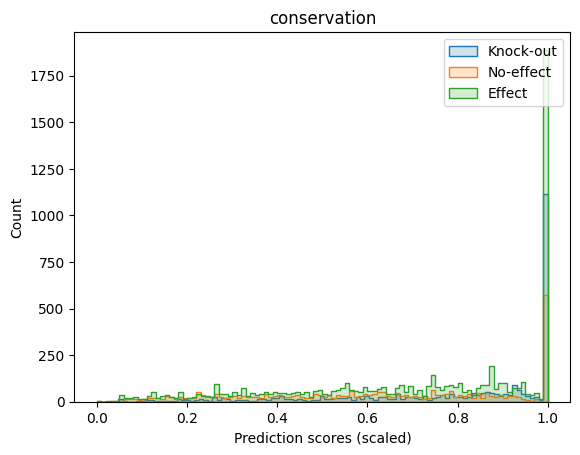

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_distribution(result_df, out_dir, n_samples=None):
    df = result_df.copy(deep=True)
    plt.cla()

    effect = df[df["class"]=="Effect"]
    knock_out = df[df["class"]=="Knock-out"]
    no_effect = df[df["class"]=="No-effect"]

    if n_samples is not None:
        effect = effect.sample(n=n_samples)
        knock_out = knock_out.sample(n=n_samples)
        no_effect = no_effect.sample(n=n_samples)

    # print(effect.shape, knock_out.shape, no_effect.shape)
    bins = 100 # 20, 100, 500
    # plt.hist(knock_out["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Knock-out")
    # plt.hist(no_effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"No-effect")
    # plt.hist(effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Effect")
    
    
    sns.histplot(knock_out["pred"], bins=bins, label=f"Knock-out", element="step", alpha=.2)
    sns.histplot(no_effect["pred"], bins=bins, label=f"No-effect", element="step", alpha=.2)
    sns.histplot(effect["pred"], bins=bins, label=f"Effect", element="step", alpha=.2)
    
    plt.title(f"{model_name}")
    plt.legend()
    plt.xlabel("Prediction scores (scaled)")
    plt.ylabel("Count")
    # plt.show()
    plt.savefig(home_dir+f"{out_dir}{model_name}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=0.0)

df = result_df[result_df["crossref"].apply(lambda x: True if "HUMAN" in x else False)] # number of human entries: 16996
out_dir="models/aa_common/pred_scores_distribution_plots_pmd_human_analysis/"
n_samples=None
is_dbnsfp_ok = True

# df = result_df[result_df["crossref"].apply(lambda x: False if "HUMAN" in x else True)] # number of human entries: 43660
# out_dir="models/aa_common/pred_scores_distribution_plots_pmd_nonhuman_analysis/"
# n_samples=3000
# is_dbnsfp_ok = False

for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    # model_name = "sift_snpdbe"
    if model_root=="dbnsfp" and not is_dbnsfp_ok: continue
    
    print(model_name)
    model_pred_col = model_name + "_pred"
    if model_name=="random_classifier": 
        df[model_pred_col] = [random.uniform(0,1) for i in range(df.shape[0])]

    df["pred"]=(df[model_pred_col]-df[model_pred_col].min())/(df[model_pred_col].max()-df[model_pred_col].min()) # scaling prediction scores between [0, 1]

    non_nan_result_df = df[~pd.isna(df[model_pred_col])]  # taking df for only non-NAN values
        
    if model_name in models_smaller_means_damaging:
        non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)

    plot_distribution(non_nan_result_df, out_dir, n_samples)
    # break



	AUC-PR: 0.361
(25873,)
	Best F1-Score: 0.655 at threshold: 0.000
(25868,)
[0.48721607 0.4871963  0.48717652 ... 0.14285714 0.16666667 1.        ]
[1.00000000e+00 9.99920849e-01 9.99841697e-01 ... 7.91514960e-05
 7.91514960e-05 0.00000000e+00]


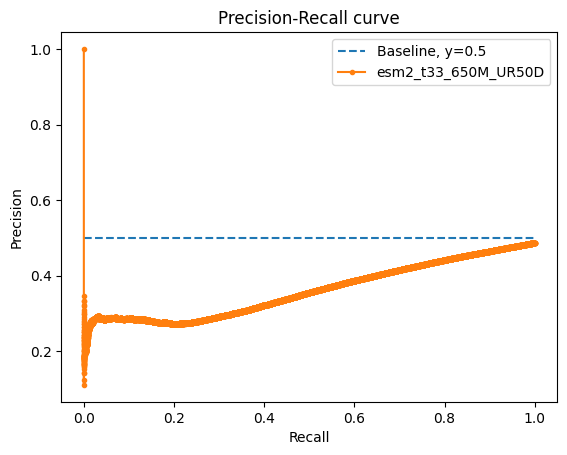

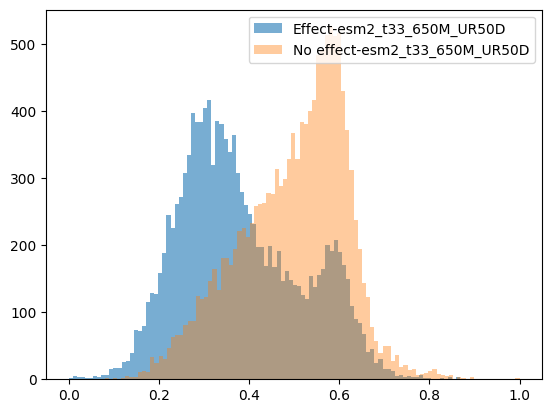

In [7]:

    

model_name = "esm2_t33_650M_UR50D"
model_pred_col = model_name + "_pred"

result_df.loc[result_df["functional_effect"]=="Effect", "class_numeric"] = 1
result_df.loc[result_df["functional_effect"]=="No effect", "class_numeric"] = 0

result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values

if model_name in models_smaller_means_damaging:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
print(thresholds.shape)
f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
print(thresholds.shape)
print(precisions, recalls, sep="\n")

# f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th_(non_nan_result_df)

import matplotlib.pyplot as plt
plt.plot([0,1], [.5, .5], linestyle='--', label='Baseline, y=0.5')
plt.plot(recalls, precisions, marker='.', label=f'{model_name}')
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Precision-Recall curve")
plt.show()


effect = result_df[result_df["functional_effect"]=="Effect"]
no_effect = result_df[result_df["functional_effect"]=="No effect"]

bins = 100 # 20, 100, 500
plt.hist(effect["pred"], bins=bins, density=False, log=False, alpha=.6, label=f"Effect-{model_name}")
plt.hist(no_effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"No effect-{model_name}")

plt.legend()
plt.show()